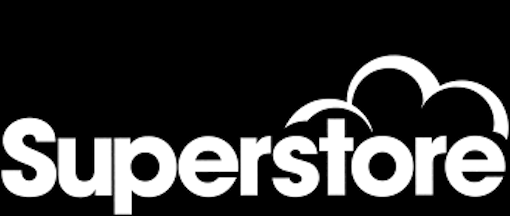

---

### SUMMARY

1. [Load the Data and Feature Engineering](#1)
2. [Exploratory Data Analysis](#2)
3. [Profit and Sales Analysis](#3)
4. [Customer Behavior and Customer Segmentation](#4)
5. [Cluster Analysis and Customer Personas](#5)
6. [Final Insights](#6)

---

<a id="1"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>1. Load the Data and Feature Engineering</div></b>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import plotly
import plotly.express as px
import plotly.graph_objs as gobj
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from plotly import figure_factory as FF

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

from warnings import simplefilter
simplefilter("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/superstore-dataset/Sample - Superstore.csv
/kaggle/input/superstore-dataset-final/Sample - Superstore.csv


In [2]:
#data = pd.read_csv('/kaggle/input/superstore-dataset/Sample - Superstore.csv',encoding='ISO-8859-1')
data = pd.read_csv('/kaggle/input/superstore-dataset-final/Sample - Superstore.csv',encoding='ISO-8859-1')

pd.set_option('display.max_columns',50)

data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**Columns and their meaning (whenever it is not obvious)**

1. **Row ID.** This is just the row number.
2. **Order ID.** 
3. **Order Date.** 
4. **Ship Date.** 
5. **Ship Mode.** Shipping (or delivery) category: first class, second class ...
6. **Customer ID.**
7. **Customer Name.**
8. **Segment.** Type of customer/client: consumer, corporate or home office.
9. **Country.** Customer's country.
10. **City.** Customer's city.
11. **State.** Customer's state.
12. **Postal Code.**
13. **Region.**
14. **Product ID.**
15. **Category.** Shipped product category: furniture, office supplies or technology.
16. **Sub-Category.** Product sub-category: bookcases, chairs, labels, tables, and so on.
17. **Product Name.**
18. **Sales.** Total price of the products sold.
19. **Quantity.** Quantity of items sold.
20. **Discount.** It is a float between 0 and 1 and it represents the discount rate applied to the specific order.
21. **Profit.** Superstore profit for this particular order.

Some columns (like *Row ID*) might be useless for our purpose. Some of them might be redundant (like *Customer ID* and *Customer Name*, that provide the same information). Later we will decide whether to drop some of them.

In [3]:
print('The dataset has {} rows and {} columns.'.format(data.shape[0],data.shape[1]))

The dataset has 9994 rows and 21 columns.


### 1.1 Null and Duplicate Values; Basic Statistics

In [4]:
data.isna().sum()

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

There are no null values in the dataset.

In [5]:
print('There are {} duplicate values out of {}.'.format(data.duplicated().sum(),
      data.shape[0]))

There are 0 duplicate values out of 9994.


I am also having a look at the column data types.

In [6]:
data.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

The majority of columns are of object (or string) type. At least two of them (*Order Date* and *Ship Date*) may have to be converted into date type. <br>
There are also columns whose values are numeric, like *Sales* and *Quantity*.

Finally, let's have a look at the basic statistics on our data, starting from the numerical features ...

In [7]:
data.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


... and then moving to the stats on the categorical ones.

In [8]:
data.describe(include="object").T

,count,unique,top,freq
Order ID,9994,5009,CA-2017-100111,14
Order Date,9994,1237,9/5/2016,38
Ship Date,9994,1334,12/16/2015,35
Ship Mode,9994,4,Standard Class,5968
Customer ID,9994,793,WB-21850,37
Customer Name,9994,793,William Brown,37
Segment,9994,3,Consumer,5191
Country,9994,1,United States,9994
City,9994,531,New York City,915
State,9994,49,California,2001


- The *Row ID* and *Postal Code* columns' statistic infos are not important. 
- The *Sales* have an average value of around 230$\$$, with a standard deviation of around 623$\$$. This tells us that the sales distribution is quite spread. The maximum sale amounts to almost 23K, the minimum to less than 1$\$$.
- *Quantity* (the quantity of items sold for a single purchase) has a mean of 3.8 and a standard deviation of 2.2. The min and max values are 1 and 14, respectively.
- *Discount* ranges between 0% and 80%, with an average of almost 16%.
- The *Profit* ranges from -6.6K to 8.4K. A negative profit value is suspect and needs to be investigated.
- It is worth to note that SUPERSTORE ships in the USA only. The state, city and region with more customers are California, New York and the West, respectively. It will be interesting to find out what is the fraction of customers living on the coasts vs those from the south and the Midwest.

### 1.2 Feature Engineering on (Order and Shipping) Dates

I am converting dates from string to datetime format.

In [9]:
data['Order Date'] = pd.to_datetime(data['Order Date'],format='mixed')
data['Ship Date']  = pd.to_datetime(data['Ship Date'],format='mixed')

Let's have a look at the new data type of the date columns ...

In [10]:
print(data['Order Date'].dtype,' / ',data['Ship Date'].dtype)

datetime64[ns]  /  datetime64[ns]


... and let's also make a simple test on the newly modified columns.

In [11]:
data['Ship Date'][0] - data['Order Date'][0]

Timedelta('3 days 00:00:00')

By subtracting shipping and order dates we can get the interval between the order of a product and its arrival at the customer's home.

It can also be useful to extract more time features from these columns, like the day, month and year when the purchase took place.

In [12]:
# Add new columns year, month and day
data["year"]  = data["Order Date"].dt.year
data["month"] = data["Order Date"].dt.month_name()
data["day"]   = data["Order Date"].dt.day_name()

data[["year","month","day"]].head()

,year,month,day
0,2016,November,Tuesday
1,2016,November,Tuesday
2,2016,June,Sunday
3,2015,October,Sunday
4,2015,October,Sunday


### 1.3 Drop Some Columns

Let's find out if the total numbers of Customer IDs and Customer Names coincide.

In [13]:
data['Customer ID'].nunique(), data['Customer Name'].nunique()

(793, 793)

Yes, the numbers coincide. This means that there is a 1 to 1 correspondence between the *Customer ID*s and the *Customer Name*s and therefore one of these features is redundant and can be dropped. <br>I am dropping the *Customer Name*s because (in the real world) it is illegal to share the customers' personal information online. Even though this is likely to be a 'simulation' conducted with synthetic-generated data (the customer names are not real), I want to stick to this privacy rule.

Let's also find out whether the total number of postal codes coincides with that of the cities. If not, this means that a city can have more than one postal code.

In [14]:
data['Postal Code'].nunique(), data['City'].nunique()

(631, 531)

The number of postal codes is larger than that of the cities, which means that larger cities can have more than one postal code. However, this feature is not expected to be very useful, thus I am dropping it from the dataframe.

In [15]:
data.drop(columns=['Row ID','Customer Name','Postal Code'],axis=1,inplace=True)

Finally, let's find out how many countries are present in the dataset.

In [16]:
data['Country'].unique()

array(['United States'], dtype=object)

There is only one country, the Usa: therefore the *Country* column can be dropped because it does not provide useful information.

In [17]:
data.drop('Country',axis=1,inplace=True)

The last check is to see whether there is correspondence between the product names and their IDs. If the data were collected properly, there should be a 1 to 1 correspondence between them.

In [18]:
data['Product ID'].nunique(), data['Product Name'].nunique(), \
        (data['Product ID'].nunique() - data['Product Name'].nunique()) / data['Product Name'].nunique() * 100

(1862, 1850, 0.6486486486486486)

The difference between the number of these features is less than 1%. Therefore, for the sake of simplicity I am dropping one of the two columns (*Product ID*).

In [19]:
data.drop('Product ID',axis=1,inplace=True)

In [20]:
data.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,year,month,day
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,November,Tuesday
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,November,Tuesday
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,June,Sunday
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,October,Sunday
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,October,Sunday


<a id="2"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>2. Exploratory Data Analysis</div></b>

### 2.1 Orders and Items Sold by Area

First, I am having a look at the number of orders by area. By order I mean a single (and unique) entry in the dataset. More precisely, a unique value in the *Order ID* column. One can notice that the first and the second rows in the *data.head()* output above correspond to the same order (CA-2016-152156), while the third row (CA-2016-138688) is a different order.<br>
Clearly, all the orders are different. Different products were purchased and, most important, they were purchased in different quantities (see the column *Quantity*).
I will define the number of products purchased as *Items sold*.

In [21]:
print('The total number of orders is {}.'.format(data['Order ID'].nunique()))

The total number of orders is 5009.


**Total No. of Orders and Items Sold by State**

In [22]:
orders_by_state = data.groupby('State')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

fig = px.treemap(orders_by_state,path=['State'],values='count',width=950,height=700);
fig.update_layout(title_text='Total Orders by State',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

California is the state with the largest amount of orders (1021, 20% of the total). Wyoming is the state with the smallest amount (only 1 order).

In [23]:
print('The total amount of purchased items is {}.'.format(data['Quantity'].sum()))

The total amount of purchased items is 37873.


In [24]:
items_by_state = data.groupby('State')['Quantity'].sum().reset_index(name='items sold').sort_values(['items sold'],ascending=False)

fig = px.treemap(items_by_state,path=['State'],values='items sold',width=950,height=700);
fig.update_layout(title_text='Total Items Sold by State',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

The fractions of the purchased items by state are similar to those of the total orders by state.

**Total No. of Orders and Items Sold by Region**

In [25]:
orders_by_region = data.groupby('Region')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

items_by_region = data.groupby('Region')['Quantity'].sum().reset_index(name='items sold').sort_values(['items sold'],ascending=False)

orders_by_region['count'].sum(), items_by_region['items sold'].sum()

(5009, 37873)

In [26]:
orders_by_city = data.groupby('City')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

items_by_city = data.groupby('City')['Quantity'].sum().reset_index(name='items sold').sort_values(['items sold'],ascending=False)

orders_by_city['count'].sum(), items_by_city['items sold'].sum()

(5009, 37873)

<Figure size 1000x700 with 0 Axes>

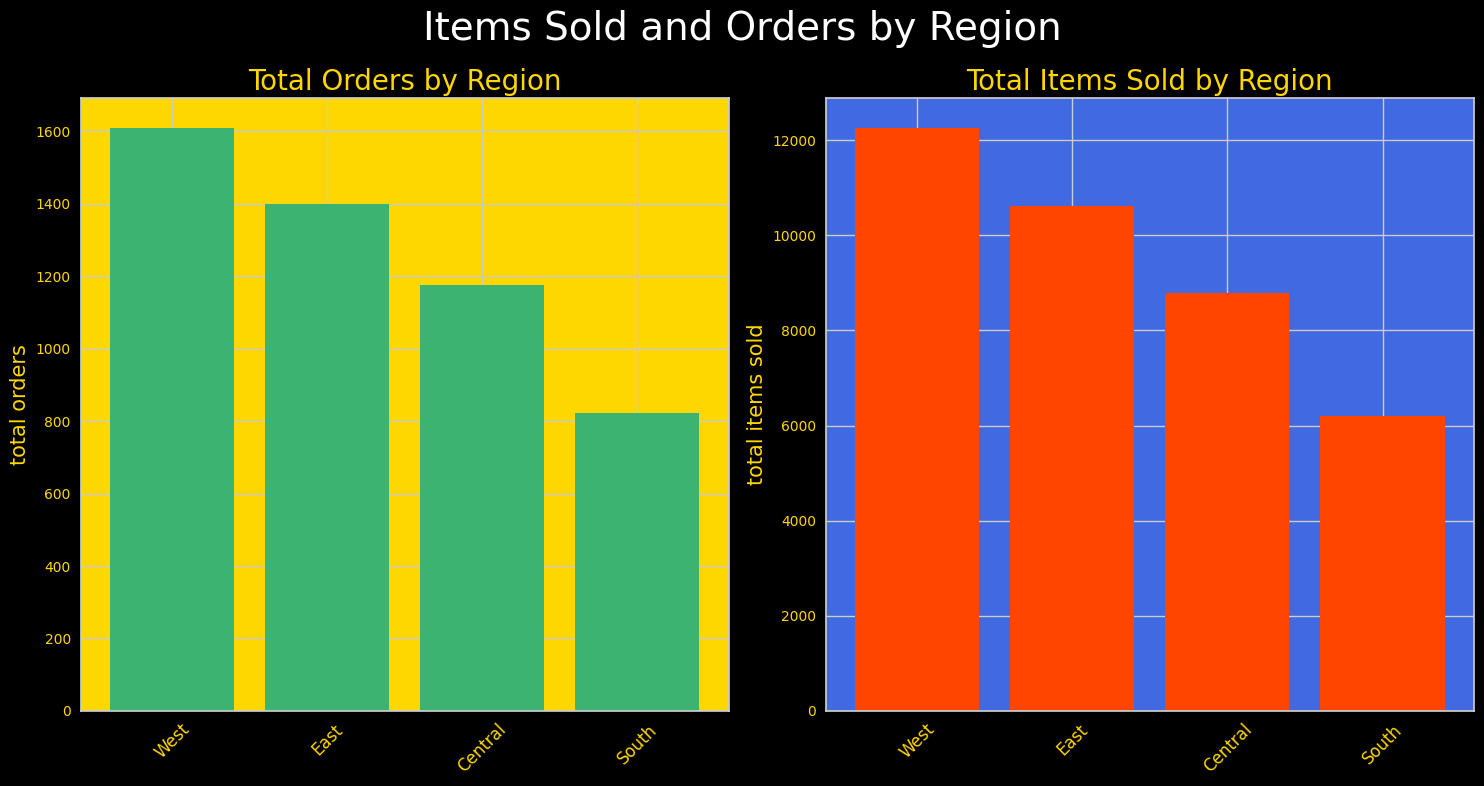

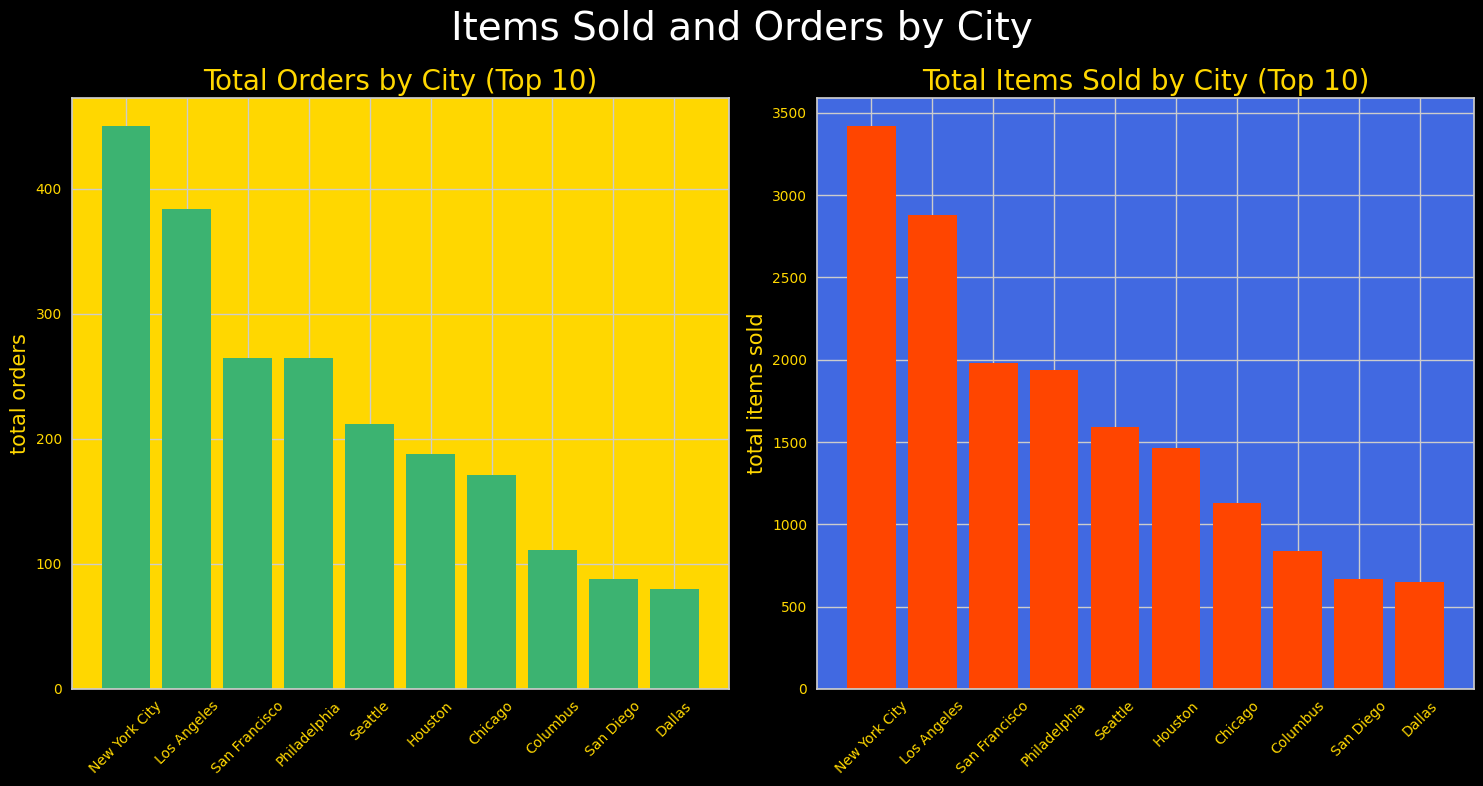

In [27]:
obc = orders_by_city.head(10)
ibc = items_by_city.head(10)

fig = plt.figure(figsize=(10,7));
(topfig,bottomfig) = fig.subfigures(2,1);

# Top figure
topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,2,figsize=(15,8));

axes[0].bar(x=orders_by_region['Region'],height=orders_by_region['count'],color='mediumseagreen');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,fontsize=12,color='gold');
axes[0].set_yticklabels(axes[0].get_yticklabels(),fontsize=10,color='gold');
axes[0].set_ylabel('total orders',fontsize=15,color='gold')
axes[0].set_title('Total Orders by Region',fontsize=20,color='gold');
axes[0].set_facecolor('gold')

axes[1].bar(x=items_by_region['Region'],height=items_by_region['items sold'],color='orangered');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,fontsize=12,color='gold');
axes[1].set_yticklabels(axes[1].get_yticklabels(),fontsize=10,color='gold');
axes[1].set_ylabel('total items sold',fontsize=15,color='gold')
axes[1].set_title('Total Items Sold by Region',fontsize=20,color='gold');
axes[1].set_facecolor('royalblue')

fig.suptitle("Items Sold and Orders by Region",fontsize=28,color='white')
fig.set_facecolor('black')
plt.tight_layout()

# Bottom figure
bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,2,figsize=(15,8));

axes[0].bar(x=obc['City'],height=obc['count'],color='mediumseagreen');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,fontsize=10,color='gold');
axes[0].set_yticklabels(axes[0].get_yticklabels(),fontsize=10,color='gold');
axes[0].set_ylabel('total orders',fontsize=15,color='gold')
axes[0].set_title('Total Orders by City (Top 10)',fontsize=20,color='gold');
axes[0].set_facecolor('gold')

axes[1].bar(x=obc['City'],height=ibc['items sold'],color='orangered');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,fontsize=10,color='gold');
axes[1].set_yticklabels(axes[1].get_yticklabels(),fontsize=10,color='gold');
axes[1].set_ylabel('total items sold',fontsize=15,color='gold')
axes[1].set_title('Total Items Sold by City (Top 10)',fontsize=20,color='gold');
axes[1].set_facecolor('royalblue')

fig.suptitle("Items Sold and Orders by City",fontsize=28,color='white')
fig.set_facecolor('black')
plt.tight_layout()

plt.tight_layout()
plt.show()

The West is the top selling region, New York is the top selling city.

### 2.2 Orders and Items Sold by Category

**Orders by Category**

In [28]:
orders_by_category = data.groupby('Category')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

items_by_category = data.groupby(['Category','Sub-Category'])['Quantity'].sum().reset_index(name='items sold').sort_values(['Category','items sold'],ascending=False)

In [29]:
orders_by_category

,Category,count
1,Office Supplies,3742
0,Furniture,1764
2,Technology,1544


In [30]:
orders_by_category['count'].sum()

7050

**Please Note.** If one sums the counts over *order_by_category*, one expects to find the total number of orders (5009). However, the number one gets (7050) is larger than 5009. This is because an order is identified by a single *Order ID*, but it can span over multiple rows of the dataframe: this means that a customer can buy multiple items, belonging to different product categories.

In [31]:
items_by_category['items sold'].sum(), data['Quantity'].sum()

(37873, 37873)

On the contrary, if one sums the number of items sold within *items_by_category*, one gets 37873 (that is the total number of items sold by Superstore).

In [32]:
items_by_category['All'] = 'All'

fig = px.treemap(items_by_category,path=['All','Category','Sub-Category'],values='items sold',width=950,height=700);
fig.update_layout(title_text='Total Items Sold by Category',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

**Orders by Category and Region**

In [33]:
category_by_regions = data.groupby(['Category','Region'])['Quantity'].sum().reset_index(name='items sold').sort_values(['Region','items sold'],ascending=False)

category_by_regions['items sold'].sum(), data['Quantity'].sum()

(37873, 37873)

In [34]:
category_by_regions['All'] = 'All'

fig = px.treemap(category_by_regions,path=['All','Region','Category'],values='items sold',width=950,height=700);
fig.update_layout(title_text='Total Items Sold by Category and Region',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

### 2.3 Top Selling Products

**Products by Order**

I am counting the number of orders by product name.

In [35]:
products_by_order = data.groupby('Product Name')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

products_by_order['count'].sum(), data['Order ID'].nunique()

(9986, 5009)

**Please Note.** As in the case of *order_by_category*, the number that we get here is larger than the number of total orders. This is because an order is identified by a single Order ID, but it can span over multiple rows of the dataframe: this means that a customer can place an order of multiple products.

In [36]:
orders_by_category['count'].sum()

7050

If the total number of *products_by_order* (9986) is larger than that of *orders_by_category* (7050), then we expect the total number of *orders_by_subcategory* to be halfway between these numbers (7050 and 9986). This is because, in a product hierarchy, product (name) preceeds sub-category and sub-category comes before category. In other words, the number of products is larger than that of product subcategories and this is larger than that of the product categories.
<br> Let's find out if this is true.

In [37]:
orders_by_subcategory = data.groupby('Sub-Category')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

orders_by_subcategory['count'].sum()

9159

Yes, this is how we expected.

Now, let's find out what are the top selling products.

In [38]:
pd.set_option('display.max_colwidth',None)

products_by_order = products_by_order.head(10)
products_by_order

,Product Name,count
1493,Staple envelope,48
1499,Staples,46
537,Easy-staple paper,46
259,Avery Non-Stick Binders,20
1500,Staples in misc. colors,19
1496,Staple remover,18
942,KI Adjustable-Height Table,18
1511,Storex Dura Pro Binders,17
1497,Staple-based wall hangings,16
993,Logitech 910-002974 M325 Wireless Mouse for Web Scrolling,15


We can also have a look at the *products_by_items*. These are calculated by considering the orders and summing over the product quantities.

In [39]:
products_by_items = data.groupby('Product Name')['Quantity'].sum().reset_index(name='items sold').sort_values(['items sold'],ascending=False)

products_by_items['items sold'].sum(), data['Quantity'].sum()

(37873, 37873)

And now, let's have a look at the top 10 selling products.

In [40]:
products_by_items = products_by_items.head(10)
total_items = data['Quantity'].sum()
products_by_items['percent of items sold'] = products_by_items['items sold'] / total_items*100

products_by_items

,Product Name,items sold,percent of items sold
1499,Staples,215,0.567687
1493,Staple envelope,170,0.448869
537,Easy-staple paper,150,0.396061
1500,Staples in misc. colors,86,0.227075
942,KI Adjustable-Height Table,74,0.195390
259,Avery Non-Stick Binders,71,0.187469
1511,Storex Dura Pro Binders,71,0.187469
699,GBC Premium Transparent Covers with Diagonal Lined Pattern,67,0.176907
1450,"Situations Contoured Folding Chairs, 4/Set",64,0.168986
1497,Staple-based wall hangings,62,0.163705


I am changing the label names that are too long.

In [41]:
products_by_order = products_by_order.replace('Logitech 910-002974 M325 Wireless Mouse for Web Scrolling','Logitech Wireless Mouse')

products_by_items = products_by_items.replace('GBC Premium Transparent Covers with Diagonal Lined Pattern','GBC Transparent Covers')

products_by_items = products_by_items.replace('Situations Contoured Folding Chairs, 4/Set','Situations Folding Chairs')

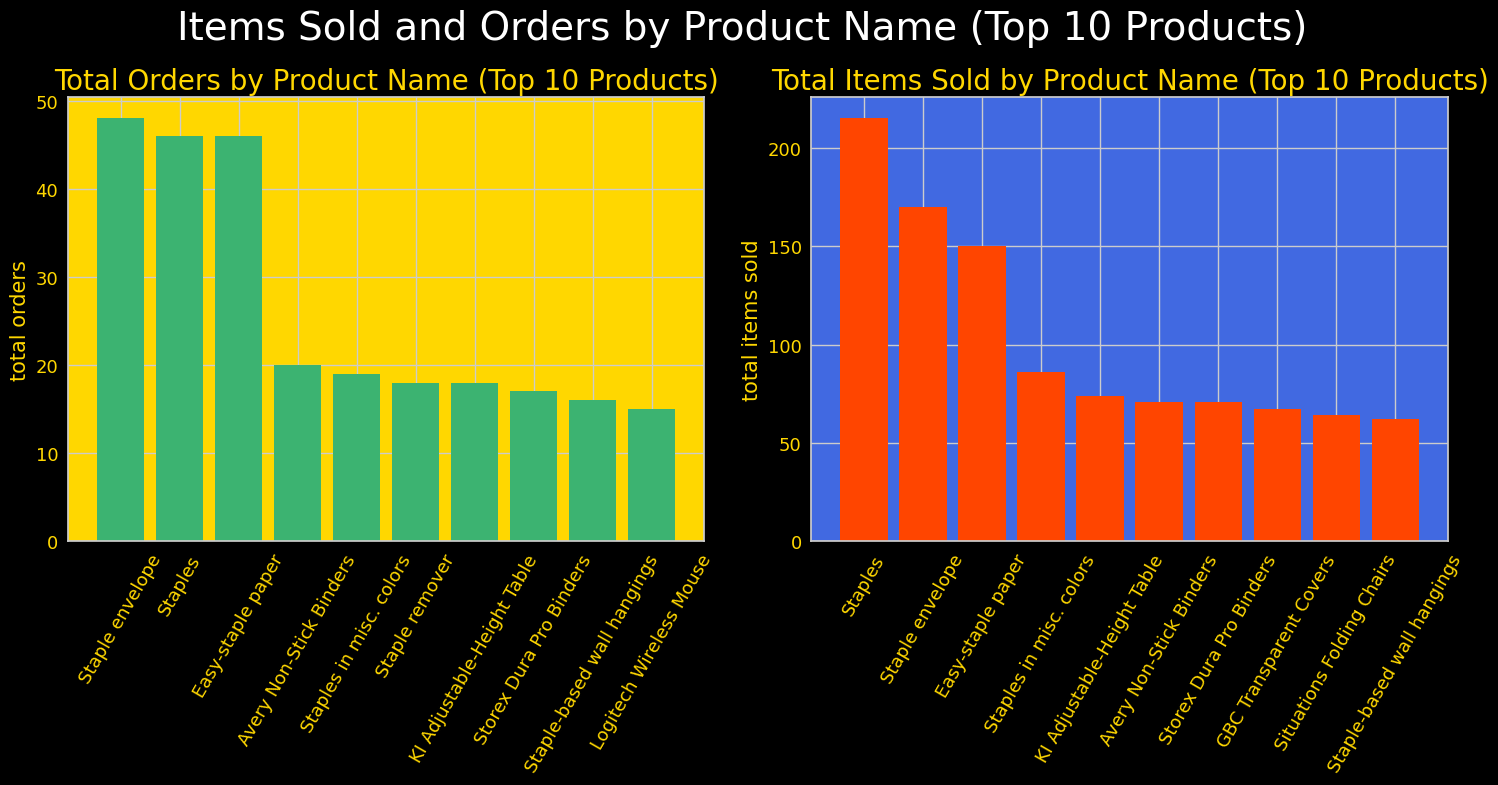

In [42]:
fig,axes = plt.subplots(1,2,figsize=(15,8));

axes[0].bar(x=products_by_order['Product Name'],height=products_by_order['count'],color='mediumseagreen');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=60,fontsize=12,color='gold');
axes[0].set_yticklabels(axes[0].get_yticklabels(),fontsize=10,color='gold');
axes[0].xaxis.set_tick_params(labelsize=13,color='gold')
axes[0].yaxis.set_tick_params(labelsize=13,color='gold')
axes[0].set_ylabel('total orders',fontsize=15,color='gold')
axes[0].set_title('Total Orders by Product Name (Top 10 Products)',fontsize=20,color='gold');
axes[0].set_facecolor('gold')

axes[1].bar(x=products_by_items['Product Name'],height=products_by_items['items sold'],color='orangered');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=60,fontsize=12,color='gold');
axes[1].set_yticklabels(axes[1].get_yticklabels(),fontsize=10,color='gold');
axes[1].xaxis.set_tick_params(labelsize=13,color='gold')
axes[1].yaxis.set_tick_params(labelsize=13,color='gold')
axes[1].set_ylabel('total items sold',fontsize=15,color='gold')
axes[1].set_title('Total Items Sold by Product Name (Top 10 Products)',fontsize=20,color='gold');
axes[1].set_facecolor('royalblue')

fig.suptitle("Items Sold and Orders by Product Name (Top 10 Products)",fontsize=28,color='white')
fig.set_facecolor('black')
plt.tight_layout()

### 2.4 Shipping Analysis

**Orders by Ship Mode and Region**

First, I want to find out what is the fraction of orders and items sold by *Ship Mode*.

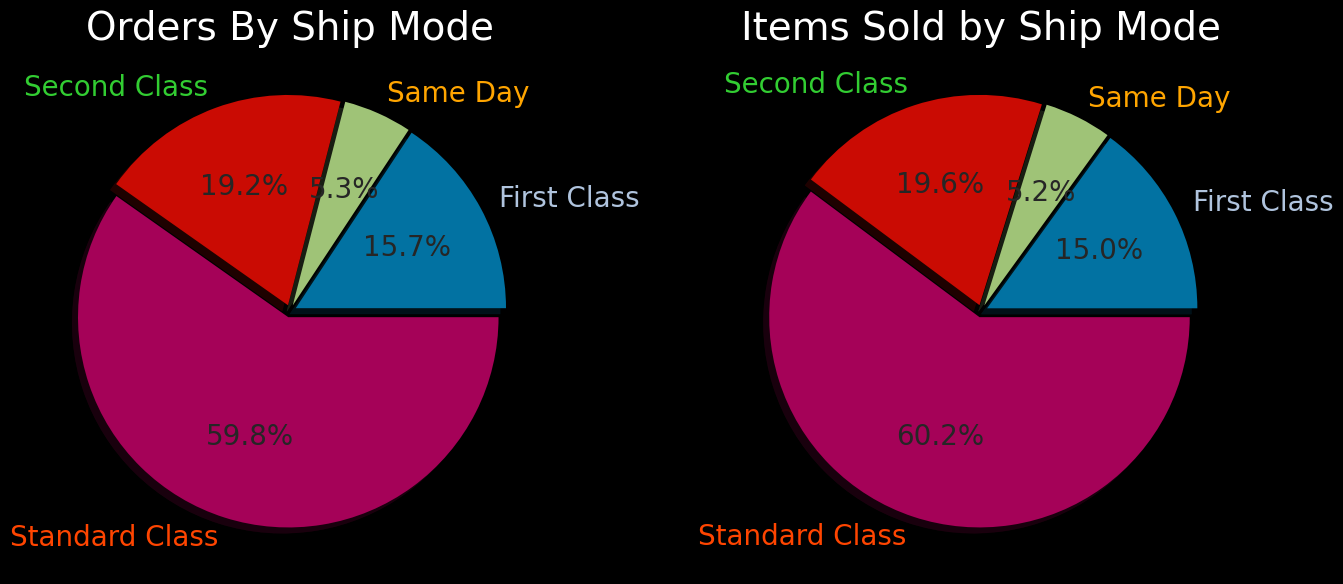

In [43]:
val3 = data.groupby('Ship Mode')['Order ID'].nunique()
labels3 = ['First Class','Same Day','Second Class','Standard Class']
colorlist3 = ['lightsteelblue','orange','limegreen','orangered']

val4 = data.groupby('Ship Mode')['Quantity'].sum()
labels4 = ['First Class','Same Day','Second Class','Standard Class']
colorlist4 = ['lightsteelblue','orange','limegreen','orangered']

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

# Plot #1
wedges,texts,auto = ax1.pie(val3,labels=labels3,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03,0.03))
ax1.set_title('Orders By Ship Mode',color='white',fontsize=28)
for text,color in zip(texts,colorlist3):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')

# Plot #2
wedges,texts,auto = ax2.pie(val4,labels=labels4,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03,0.03))
ax2.set_title('Items Sold by Ship Mode',color='white',fontsize=28)
for text,color in zip(texts,colorlist4):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')


plt.tight_layout()
plt.show()

I also want to find out what is the average number of items ordered by *Ship Mode*.

In [44]:
orders_by_shipmode_orderID = data.groupby(['Ship Mode','Order ID'])['Quantity'].sum().reset_index(name='count').sort_values(['count'],ascending=False)

avg_orders_by_shipmode = orders_by_shipmode_orderID.groupby('Ship Mode')['count'].mean().reset_index(name='avg no. of orders')

avg_orders_by_shipmode

,Ship Mode,avg no. of orders
0,First Class,7.233799
1,Same Day,7.424242
2,Second Class,7.700207
3,Standard Class,7.614228


Then, I want to see whether there is a difference in the *Ship Mode* by region.

In [45]:
orders_by_shipmode_region = data.groupby('Region')['Ship Mode'].value_counts(normalize=True).reset_index(name='Probability')

orders_by_shipmode_region['Percentage'] = (orders_by_shipmode_region['Probability']*100).round(2)
orders_by_shipmode_region.drop('Probability',axis=1,inplace=True)

orders_by_shipmode_region

,Region,Ship Mode,Percentage
0,Central,Standard Class,61.95
1,Central,Second Class,20.02
2,Central,First Class,12.87
3,Central,Same Day,5.17
4,East,Standard Class,58.74
5,East,Second Class,18.61
6,East,First Class,17.21
7,East,Same Day,5.44
8,South,Standard Class,60.12
9,South,Second Class,20.31


The difference in the *Ship Mode* between USA regions is little.

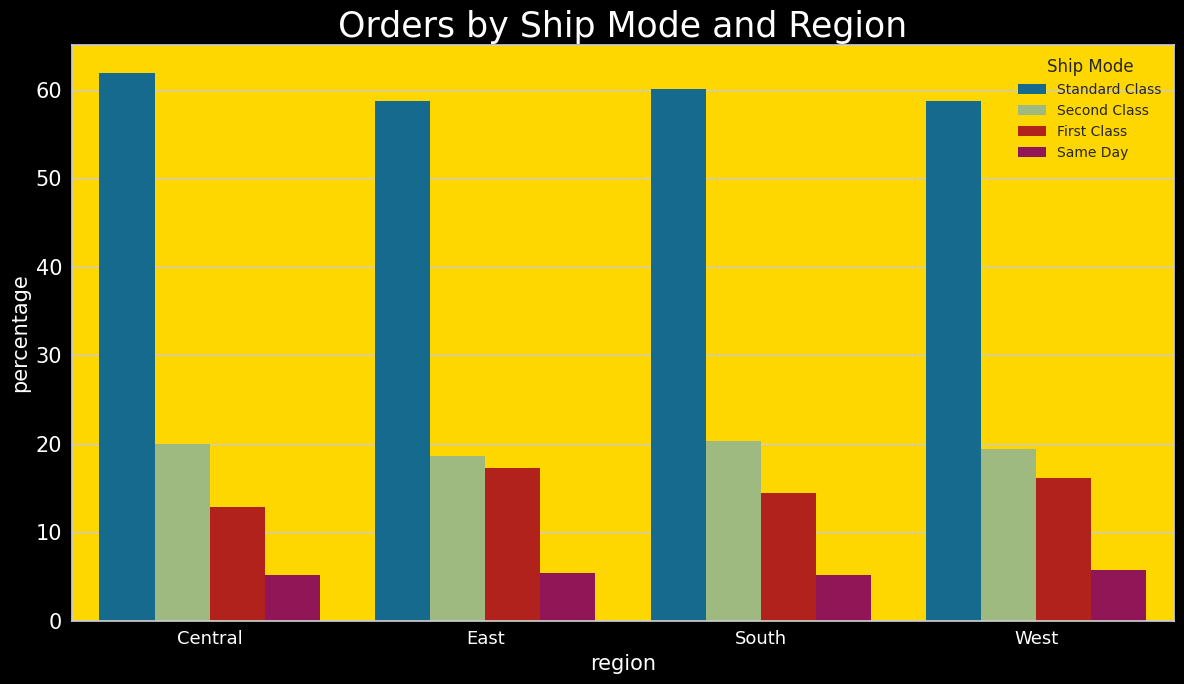

In [46]:
plt.figure(figsize=(12,7))
fig = sns.barplot(orders_by_shipmode_region,x="Region",y="Percentage",hue='Ship Mode')
#sns.move_legend(fig,"upper left",bbox_to_anchor=(1,1))

plt.xlabel("region",fontsize=15,color='white')
plt.xticks(fontsize=15,color='white')
plt.tick_params(labelsize=13,color='white')
plt.ylabel("percentage",fontsize=15,color='white')
plt.yticks(fontsize=15,color='white')
plt.title("Orders by Ship Mode and Region",fontsize=25,color='white')

plt.tight_layout()
plt.gcf().patch.set_facecolor('black')
plt.gca().set_facecolor('gold')

**Difference Between the Shipping Classes**

What is the difference between the shipping classes?
I want to see what is the amount of time between the order and the shipment depending on the *Ship Mode* class.

To do so, I am creating a new feature (*order ship time*) that accounts for the time difference between the order and the ship date.

Then, I can calculate the average time difference between the order and the shipment based on the *Ship Mode* class.

In [47]:
data['order ship time'] = data['Ship Date'] - data['Order Date']

data.groupby('Ship Mode')['order ship time'].mean().to_frame()

,order ship time
Ship Mode,
First Class,2 days 04:23:05.695708712
Same Day,0 days 01:03:38.784530386
Second Class,3 days 05:42:47.197943444
Standard Class,5 days 00:09:24.611260053


There is a huge difference between the shipping classes. The mean value of the *order ship time* ranges from 0 to 5 days.

Let's have a look at the 4 *order ship time* distributions.

In [48]:
# Copy the original dataframe
data2 = data.copy()

# Convert the time (format days:hours:minutes:seconds to hours)
data2['order ship time'] = data2['order ship time'].apply(lambda x: x.total_seconds() / 3600)
# Convert the minutes (timedelta type) to integer
data2['order ship time'] = data2['order ship time'].astype(int)

data2.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,year,month,day,order ship time
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,November,Tuesday,72
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs, Rounded Back",731.9400,3,0.00,219.5820,2016,November,Tuesday,72
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters by Universal,14.6200,2,0.00,6.8714,2016,June,Sunday,96
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,October,Sunday,168
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,October,Sunday,168


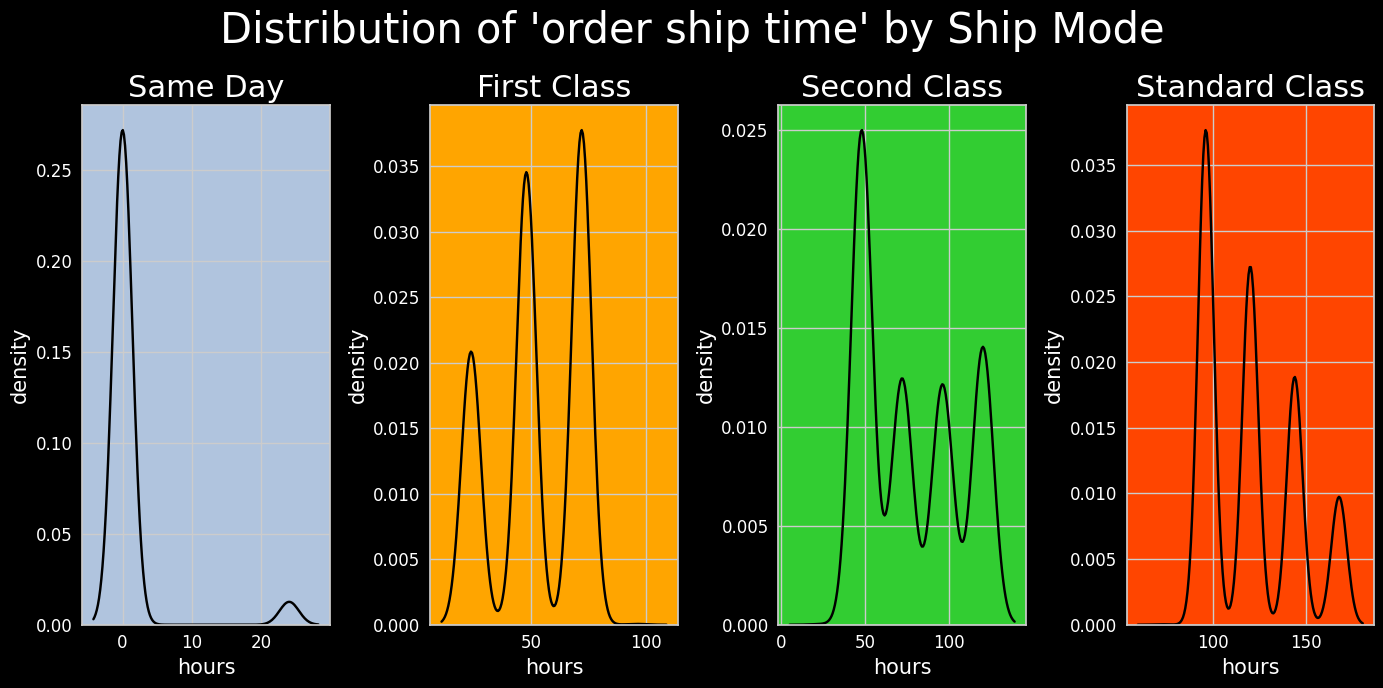

In [49]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(14,7))

ax1 = sns.distplot(data2[data2['Ship Mode'] == 'Same Day']['order ship time'],color='black',hist=False,ax=ax1)
ax1.xaxis.set_tick_params(labelsize=13,color='white')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='white')
ax1.yaxis.set_tick_params(labelsize=13,color='white')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=12,color='white')
ax1.set_facecolor('lightsteelblue')  
ax1.set_xlabel('hours',fontsize=15,color='white')
ax1.set_ylabel('density',fontsize=15,color='white')
ax1.set_title('Same Day',fontsize=22,color='white')   

ax2 = sns.distplot(data2[data2['Ship Mode'] == 'First Class']['order ship time'],color='black',hist=False,ax=ax2)
ax2.xaxis.set_tick_params(labelsize=13,color='white')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='white')
ax2.yaxis.set_tick_params(labelsize=13,color='white')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=12,color='white')
ax2.set_facecolor('orange') 
ax2.set_xlabel('hours',fontsize=15,color='white')
ax2.set_ylabel('density',fontsize=15,color='white')
ax2.set_title('First Class',fontsize=22,color='white')

ax3 = sns.distplot(data2[data2['Ship Mode'] == 'Second Class']['order ship time'],color='black',hist=False,ax=ax3)
ax3.xaxis.set_tick_params(labelsize=13,color='white')
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=12,color='white')  
ax3.yaxis.set_tick_params(labelsize=13,color='white')
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=12,color='white')
ax3.set_facecolor('limegreen')
ax3.set_xlabel('hours',fontsize=15,color='white')
ax3.set_ylabel('density',fontsize=15,color='white')
ax3.set_title('Second Class',fontsize=22,color='white')

ax4 = sns.distplot(data2[data2['Ship Mode'] == 'Standard Class']['order ship time'],color='black',hist=False,ax=ax4)
ax4.xaxis.set_tick_params(labelsize=13,color='white')
ax4.set_xticklabels(ax4.get_xticklabels(),fontsize=12,color='white')
ax4.yaxis.set_tick_params(labelsize=13,color='white')
ax4.set_yticklabels(ax4.get_yticklabels(),fontsize=12,color='white')
ax4.set_facecolor('orangered')
ax4.set_xlabel('hours',fontsize=15,color='white')
ax4.set_ylabel('density',fontsize=15,color='white')
ax4.set_title('Standard Class',fontsize=22,color='white')

fig.suptitle("Distribution of 'order ship time' by Ship Mode",fontsize=30,color='white')

fig.set_facecolor('black')
plt.tight_layout() 

It is worth to note that:
- The four distributions are multi-peaked. Only the first one (*Same Day*) has a peak that hugely dominates over the others.
- The distributions second to fourth are largely spread. This means that the delivery time is quite random.
- Final, and most important, there are delivery times of one or two hours. This is almost impossible for an e-commerce company in the real world, even for really big ones or local ones. This is a clear sign that **this data has synthetic origin.**

<a id="3"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>3. Profit and Sales Analysis</div></b>

### 3.1 Sales and Profits by Category, Year and Month

**Sales and Profits by Year**

First, I am printing the total sales, profits and sale to profit ratios of Superstore.

In [50]:
print('total sales = ${:.2f}.'.format(data['Sales'].sum()))

print('total profits = ${:.2f}.'.format(data['Profit'].sum()))

total sales = $2297200.86.
total profits = $286397.02.


The next step is to plot the sales and profits by year.

In [51]:
sales_by_year = data.groupby('year')['Sales'].sum().reset_index(name='sales').sort_values(['year'],ascending=True)

profits_by_year = data.groupby('year')['Profit'].sum().reset_index(name='profits').sort_values(['year'],ascending=True)

sales_profits = sales_by_year.copy()
sales_profits = sales_profits.merge(profits_by_year,on=['year'])

sales_profits['profit ratio'] = sales_profits['profits'] / sales_profits['sales'] * 100

sales_profits

,year,sales,profits,profit ratio
0,2014,484247.4981,49543.9741,10.231126
1,2015,470532.5090,61618.6037,13.095504
2,2016,609205.5980,81795.1743,13.426530
3,2017,733215.2552,93439.2696,12.743771


I am defining a function to print the features' values on top of the histograms. 

In [52]:
def autolabel(rects,ax,color,FS):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        if height > 0:            
            ax.text(rect.get_x() + rect.get_width()/2.,1.02*height,
                    '%d' % int(height),
                    ha='center',va='bottom',fontsize=FS,color=color)
        else:
            ax.text(rect.get_x() + rect.get_width()/2.,-0.001*height,
                    '%d' % int(height),
                    ha='center',va='bottom',fontsize=FS,color=color)

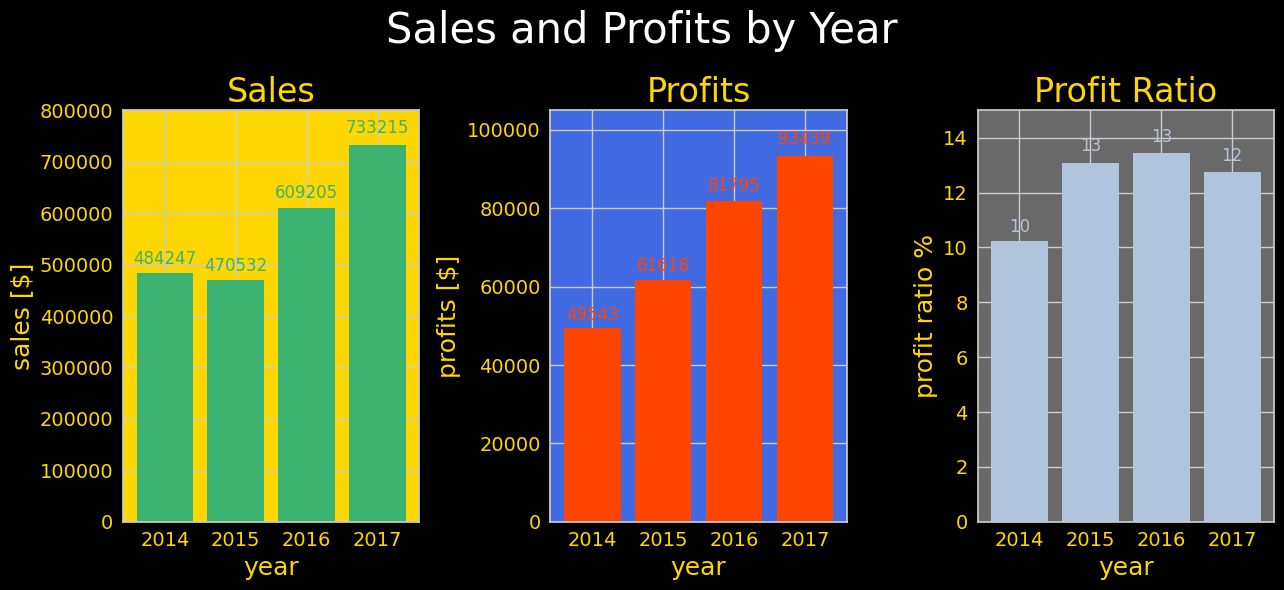

In [53]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(13,6))

### Plot #1 ###
fig1 = ax1.bar(sales_profits['year'],sales_profits['sales'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,800000])
ax1.set_title('Sales',fontsize=24,color='gold')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xlabel('year',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('sales [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',12)
    
### Plot #2 ###
fig2 = ax2.bar(sales_profits['year'],sales_profits['profits'],color='orangered',linewidth=3)
ax2.set_ylim([0,105000])
ax2.set_title('Profits',fontsize=24,color='gold')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xlabel('year',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('profits [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',12)

### Plot #3 ###
fig3 = ax3.bar(sales_profits['year'],sales_profits['profit ratio'],color='lightsteelblue',linewidth=3)
ax3.set_ylim([0,15])
ax3.set_title('Profit Ratio',fontsize=24,color='gold')
ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
ax3.xaxis.set_tick_params(labelsize=13,color='gold')
ax3.set_xlabel('year',fontsize=18,color='gold')
ax3.yaxis.set_tick_params(labelsize=13,color='gold')
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=12,color='gold')
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=10,color='gold')
ax3.set_ylabel('profit ratio %',fontsize=18,color='gold')
ax3.yaxis.set_tick_params(labelsize=14)
ax3.set_xticklabels(ax3.get_xticklabels())
ax3.xaxis.set_tick_params(labelsize=14)
ax3.set_facecolor('dimgrey')
autolabel(fig3,ax3,'lightsteelblue',12)

fig.suptitle("Sales and Profits by Year",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

It is worth to note that:
- The sales and profits have increased in the 2014-2017 time frame.
- The sale to profit ratio increased between 2014 and 2015 and then it stayed pretty stable.
- Thus, in order to increase the profits, the company should either increase the sales or the sale to profit ratio.

**Sales and Profits by Month**

In [54]:
sales_by_month = data.groupby('month')['Sales'].sum().reset_index(name='sales').sort_values(['month'],ascending=True)

profits_by_month = data.groupby('month')['Profit'].sum().reset_index(name='profits').sort_values(['month'],ascending=True)

# I am dividing by four to average over the years 2014-2017
sales_by_month['sales']     = sales_by_month['sales'] / 4
profits_by_month['profits'] = profits_by_month['profits'] / 4

sales_profits_by_month = sales_by_month.copy()
sales_profits_by_month = sales_profits_by_month.merge(profits_by_month,on=['month'])

# Check
sales_profits_by_month['sales'].sum() * 4, data['Sales'].sum()

(2297200.8603, 2297200.8603000003)

I have to sort the months in the right order.
<br> See: https://stackoverflow.com/questions/69658538/how-to-sort-a-column-by-a-given-list-in-pandas-dataframe.

In [55]:
# Sorting the months in the right order
order = ['January','February','March','April','May','June','July',
          'August','September','October','November','December']

sales_profits_by_month = sales_profits_by_month.set_index('month')
sales_profits_by_month = sales_profits_by_month.reindex(index = order)
sales_profits_by_month = sales_profits_by_month.reset_index()

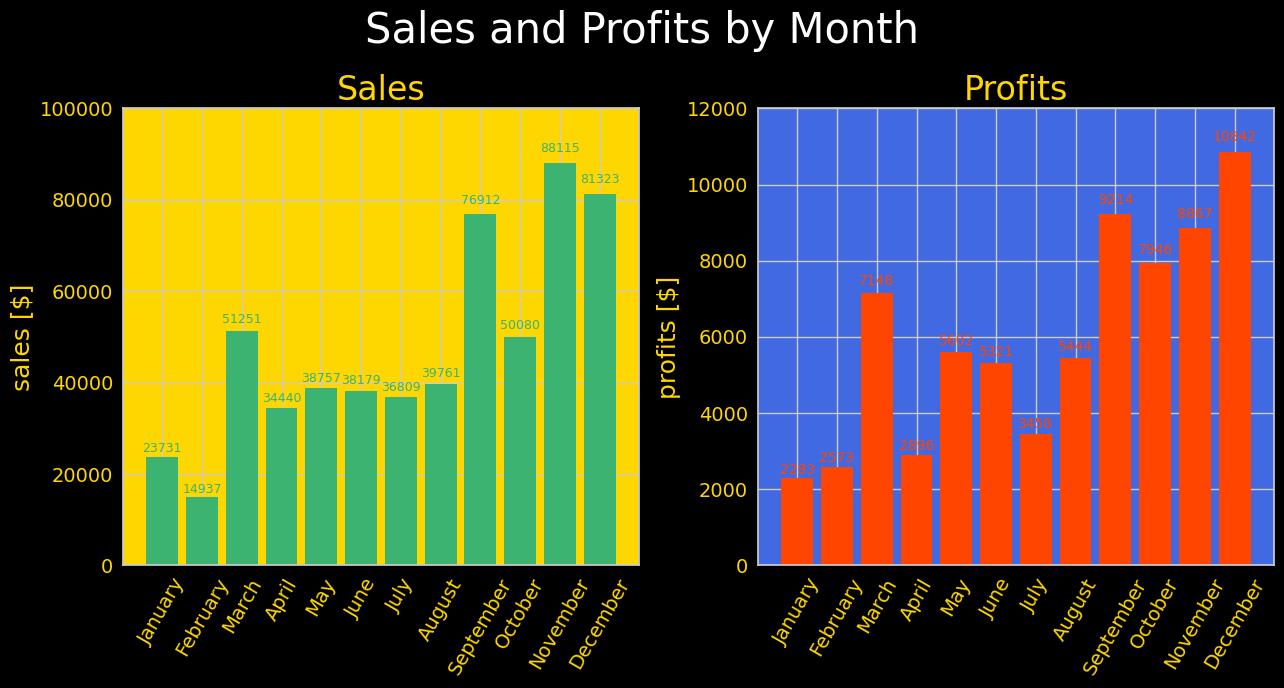

In [56]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,7))

### Plot #1 ###
fig1 = ax1.bar(sales_profits_by_month['month'],sales_profits_by_month['sales'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,100000])
ax1.set_title('Sales',fontsize=24,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('sales [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=60)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',9)

### Plot #2 ###
fig2 = ax2.bar(sales_profits_by_month['month'],sales_profits_by_month['profits'],color='orangered',linewidth=3)
ax2.set_ylim([0,12000])
ax2.set_title('Profits',fontsize=24,color='gold')
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('profits [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=60)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',10)

fig.suptitle("Sales and Profits by Month",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

It is worth to note that:
- As expected, November and December are the months with the highest sales. This is because of Christmas holidays and the end of the year.
- January and February are the months with the lowest amount of sales. This is because people do not have much money to spend after the Christmas holidays.
- I am not sure why September sales are so high. This is worth to check.

Now, let's see what are the products that sell the most in each month.

In [57]:
category_by_month = data.groupby(['Category','month'])['Sales'].sum().reset_index(name='sales') #.sort_values(['Segment','items sold'],ascending=False)

category_by_month['sales'].sum(), data['Sales'].sum()

(2297200.8602999994, 2297200.8603000003)

In [58]:
category_by_month['All'] = 'All'

fig = px.treemap(category_by_month,path=['All','Category','month'],values='sales',width=950,height=700);
fig.update_layout(title_text='Sales by Category and Month',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

One can notice that:
- Technology sells the most in November (Black Friday?).
- Furniture sells the most In November and December.
- Office Supplies sell the most in September, November and December.

**Sales and Profits by Category**

I want to find out what are the fractions of sales and profits from the three product categories.

In [59]:
total_sales = data['Sales'].sum()

sales_table = data.groupby(['Category'])['Sales'].sum().reset_index(name='sales').sort_values(['sales'],ascending=False)

sales_table['sales fraction'] = sales_table['sales'] / total_sales * 100


total_profits = data['Profit'].sum()

profits_table = data.groupby(['Category'])['Profit'].sum().reset_index(name='profits').sort_values(['profits'],ascending=False)

profits_table['profits fraction'] = profits_table['profits'] / total_profits * 100

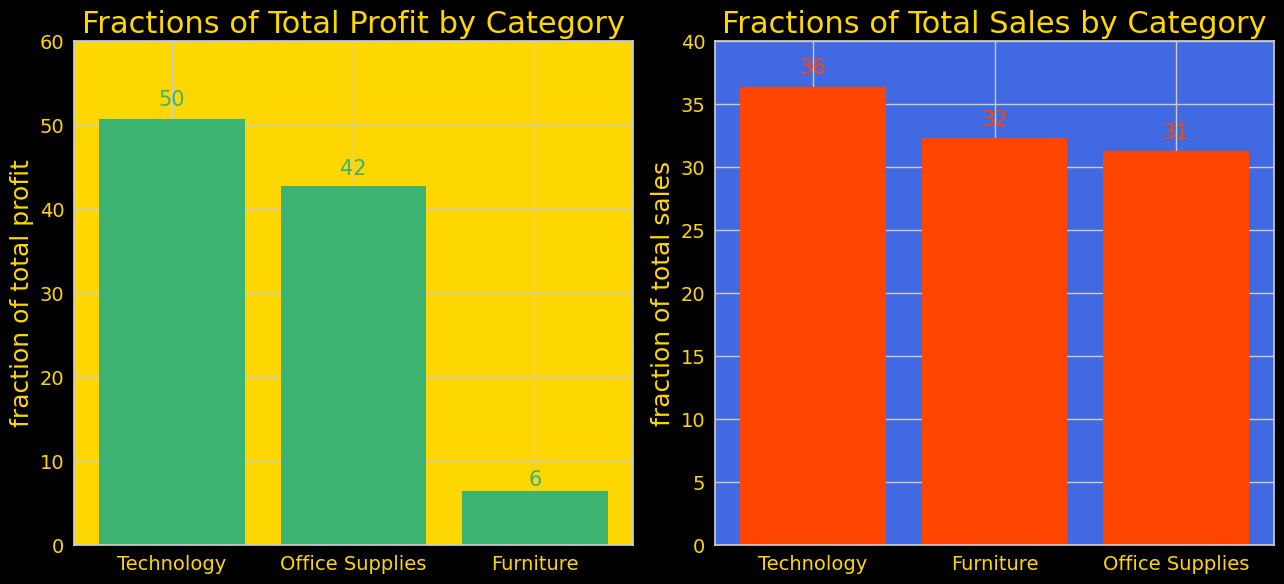

In [60]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,6))

### Plot #1 ###
fig1 = ax1.bar(profits_table['Category'],profits_table['profits fraction'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,60])
ax1.set_title('Fractions of Total Profit by Category',fontsize=22,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('fraction of total profit',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',15)

### Plot #2 ###
fig2 = ax2.bar(sales_table['Category'],sales_table['sales fraction'],color='orangered',linewidth=3)
ax2.set_ylim([0,40])
ax2.set_title('Fractions of Total Sales by Category',fontsize=22,color='gold')
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('fraction of total sales',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',15)

fig.set_facecolor('black')
plt.tight_layout()

One can notice that:
- Technology is the highest selling category. However, there is not a huge difference between the sales in technology and those in furniture and office supplies.
- In the case of profits, the situation is completely different. Technology and office supplies secure high profits, while furniture very low ones.

### 3.2 Discounts

Let's discuss the discount that have been offered by Superstore in the years 2014-2017.

In [61]:
print('average discount = {:.1f}%.'.format(data['Discount'].mean() * 100))

average discount = 15.6%.


The average discount rate is pretty high. It might be hard to make profits with such low margins.

Let's see how the discount rate has changed through the years and months.

In [62]:
discount_by_year = (data.groupby('year')['Discount'].mean() * 100).reset_index(name='avg discount').sort_values(['year'],ascending=True)

discount_by_month = (data.groupby('month')['Discount'].mean() * 100).reset_index(name='avg discount') 

I have to sort the months in the right order.

In [63]:
discount_by_month = discount_by_month.set_index('month')
discount_by_month = discount_by_month.reindex(index = order)
discount_by_month = discount_by_month.reset_index()

In [64]:
discount_by_month

,month,avg discount
0,January,14.992126
1,February,14.623333
2,March,15.502874
3,April,16.312874
4,May,16.542857
5,June,16.281729
6,July,15.788732
7,August,15.423513
8,September,14.899494
9,October,16.260073


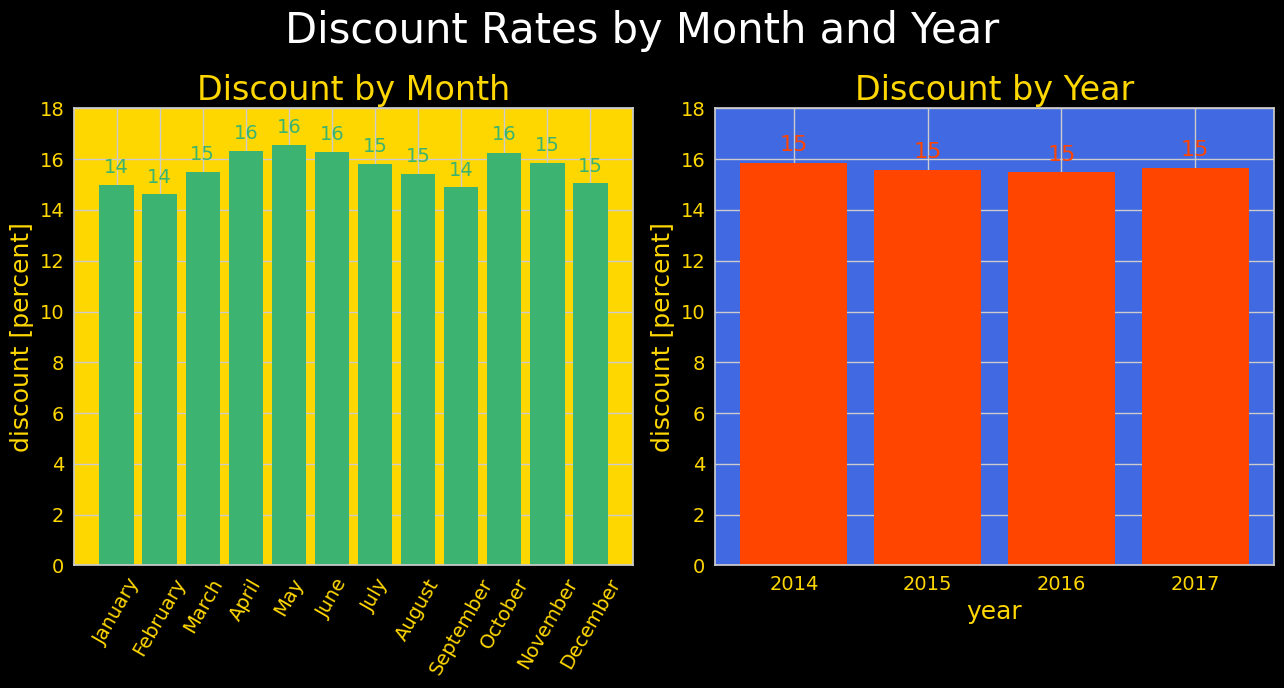

In [65]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,7))

### Plot #1 ###
fig1 = ax1.bar(discount_by_month['month'],discount_by_month['avg discount'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,18])
ax1.set_title('Discount by Month',fontsize=24,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('discount [percent]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=60)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',14)

### Plot #2 ###
fig2 = ax2.bar(discount_by_year['year'],discount_by_year['avg discount'],color='orangered',linewidth=3)
ax2.set_ylim([0,18])
ax2.set_title('Discount by Year',fontsize=24,color='gold')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xlabel('year',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('discount [percent]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',16)

fig.suptitle("Discount Rates by Month and Year",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

One can notice that:
- The average yearly discount rate did not change throughout 2014-2017.
- The discount rate oscillates during the year. It does not have a clear pattern. One would expect it to be higher during the months with low sales (like January and February) and to be lower during the most favorable months (September, November and December), but this is not the case.

### 3.3 Sales by Region

Previously, by studying the amount of items sold by Superstore, we have found out that the West is the top selling region and that New York is the top selling city. Unless there are areas where the customers buy products that are more expensive than average, we expect the trend of sales and profits to align with these findings.

In [66]:
sales_by_region = data.groupby('Region')['Sales'].sum().reset_index(name='total sales').sort_values(['total sales'],ascending=False)

sales_by_region

,Region,total sales
3,West,725457.8245
1,East,678781.2400
0,Central,501239.8908
2,South,391721.9050


In [67]:
sales_by_city = data.groupby('City')['Sales'].sum().reset_index(name='total sales').sort_values(['total sales'],ascending=False)

sales_by_city.head(5)

,City,total sales
329,New York City,256368.161
266,Los Angeles,175851.341
452,Seattle,119540.742
438,San Francisco,112669.092
374,Philadelphia,109077.013


These results confirm our previous findings.

Let's see what are the least profitable cities.

In [68]:
sales_by_city.tail(5)

,City,total sales
354,Ormond Beach,2.808
370,Pensacola,2.214
221,Jupiter,2.064
140,Elyria,1.824
1,Abilene,1.392


The sales in these small cities are extremely low. Therefore, the growth strategy of Superstore should be either to: (1) focus on the large cities and urban areas; (2) try to reach every single corner of the country.
<br> The first strategy is more reasonable.

Let's find out what is the fraction of sales that Superstores earns in the top10 (top 20) cities.

In [69]:
sales_top10_cities = (sales_by_city.head(10))['total sales'].sum()
sales_top20_cities = (sales_by_city.head(20))['total sales'].sum()

sales_minus_top10 = total_sales - sales_top10_cities
sales_minus_top20 = total_sales - sales_top20_cities

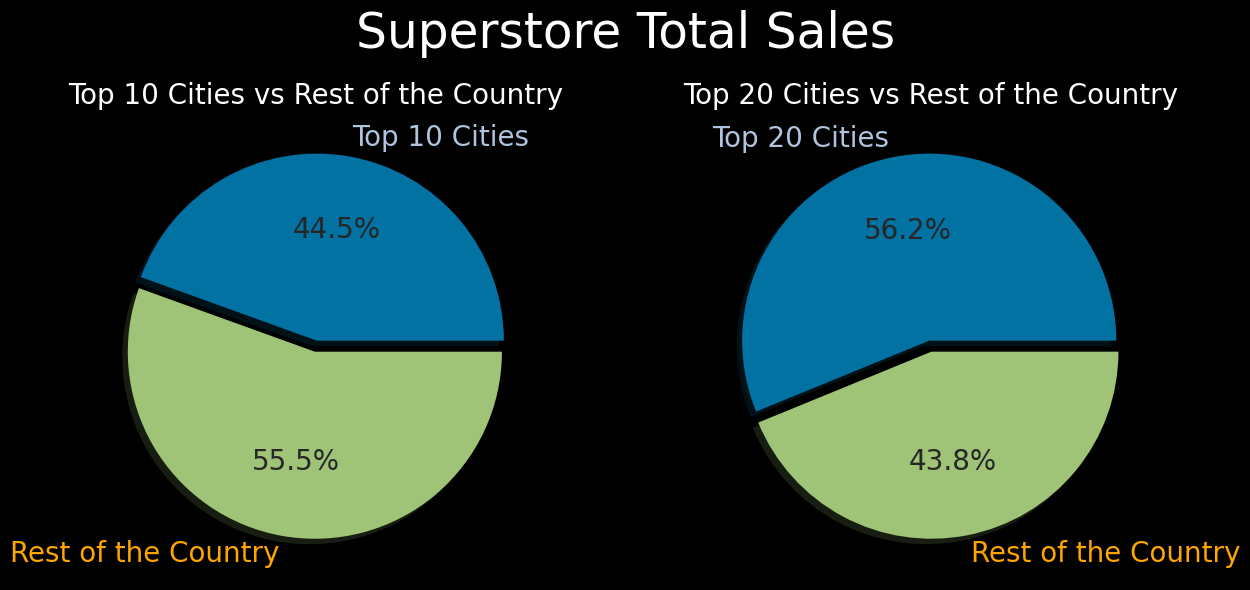

In [70]:
top10_sales_values = [sales_top10_cities,sales_minus_top10]
top10_sales_labels = ['Top 10 Cities','Rest of the Country']
colorlist = ['lightsteelblue','orange']

top20_sales_values = [sales_top20_cities,sales_minus_top20]
top20_sales_labels = ['Top 20 Cities','Rest of the Country']

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

# Plot #1
wedges,texts,auto = ax1.pie(top10_sales_values,labels=top10_sales_labels,autopct="%1.1f%%",
                            textprops={'fontsize':20},shadow=True,explode=(0.03,0.03))
ax1.set_title('Top 10 Cities vs Rest of the Country',color='white',fontsize=20)
for text,color in zip(texts,colorlist):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')

# Plot #2
wedges,texts,auto = ax2.pie(top20_sales_values,labels=top20_sales_labels,autopct="%1.1f%%",
                            textprops={'fontsize':20},shadow=True,explode=(0.03,0.03))
ax2.set_title('Top 20 Cities vs Rest of the Country',color='white',fontsize=20)
for text,color in zip(texts,colorlist):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')

fig.suptitle("Superstore Total Sales",fontsize=35,color='white')

plt.tight_layout()
plt.show()

As shown in the pie plots, the large majority of the sales is generated in the big cities.

### 3.4 Losses

**Losses by Product Sub-Category**

Not all the transactions are profitable. Some of them provide a negative profit (i.e. a loss).

In [71]:
sales_by_subcategory = data.groupby('Sub-Category')['Sales'].mean().reset_index(name='avg sales').sort_values(['Sub-Category'],ascending=False)
profit_by_subcategory = data.groupby('Sub-Category')['Profit'].mean().reset_index(name='avg profits').sort_values(['Sub-Category'],ascending=False)

sales_profit_by_subcategory = sales_by_subcategory.copy()
sales_profit_by_subcategory = sales_profit_by_subcategory.merge(profit_by_subcategory,on='Sub-Category').sort_values(['avg profits'],ascending=True)

sales_profit_by_subcategory.head(10)

,Sub-Category,avg sales,avg profits
0,Tables,648.794771,-55.565771
12,Bookcases,503.859633,-15.230509
1,Supplies,245.650200,-6.258418
8,Fasteners,13.936774,4.375660
14,Art,34.068834,8.200737
7,Furnishings,95.825668,13.645918
6,Labels,34.303055,15.236962
13,Binders,133.560560,19.843574
4,Paper,57.284092,24.856620
2,Storage,264.590553,25.152277


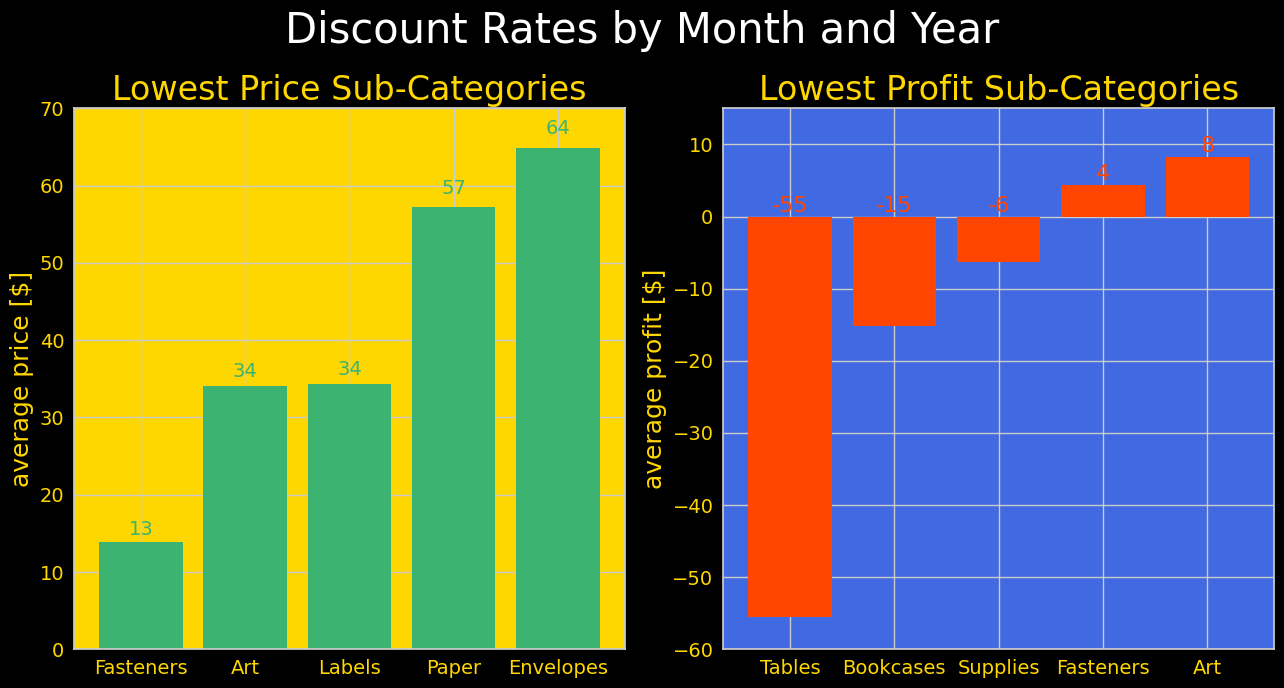

In [72]:
low_profits = (sales_profit_by_subcategory.sort_values(['avg profits'],ascending=True)).head(5)
low_sales   = (sales_profit_by_subcategory.sort_values(['avg sales'],ascending=True)).head(5)

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,7))

### Plot #1 ###
fig1 = ax1.bar(low_sales['Sub-Category'],low_sales['avg sales'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,70])
ax1.set_title('Lowest Price Sub-Categories',fontsize=24,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('average price [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels())
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',14)

### Plot #2 ###
fig2 = ax2.bar(low_profits['Sub-Category'],low_profits['avg profits'],color='orangered',linewidth=3)
ax2.set_ylim([-60,15])
ax2.set_title('Lowest Profit Sub-Categories',fontsize=24,color='gold')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('average profit [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels())
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',16)

fig.suptitle("Discount Rates by Month and Year",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

Some sub-categories of products are highly unprofitable. Unless these items are old stocks (or funds of store) that need to be sold as fast as possible, these items should be taken off the Superstore inventory.

In [73]:
print('No. of orders of tables: {}.'.format(data[data['Sub-Category'] == 'Tables']['Sub-Category'].count()))

print('No. of orders of bookcases: {}.'.format(data[data['Sub-Category'] == 'Bookcases']['Sub-Category'].count()))

print('No. of orders of supplies: {}.'.format(data[data['Sub-Category'] == 'Supplies']['Sub-Category'].count()))

No. of orders of tables: 319.
No. of orders of bookcases: 228.
No. of orders of supplies: 190.


In [74]:
data.groupby('Sub-Category')['Profit'].sum().reset_index(name='total losses [$]').sort_values(['total losses [$]'],ascending=True).head(3)

,Sub-Category,total losses [$]
16,Tables,-17725.4811
4,Bookcases,-3472.5560
15,Supplies,-1189.0995


These are the total losses (in dollars) of the unprofitable sub-categories.

**Losses by City**

I want to find out what are the least profitable cities in the 2014-2017 years.

In [75]:
profits_by_year_city = data.groupby(['City','year'])['Profit'].sum().reset_index(name='profits')

# Check
profits_by_year_city['profits'].sum(), data['Profit'].sum()

(286397.02170000004, 286397.0217)

In [76]:
least_profits_2014 = profits_by_year_city[profits_by_year_city['year'] == 2014].sort_values(['profits'],ascending=True).head(5)

least_profits_2015 = profits_by_year_city[profits_by_year_city['year'] == 2015].sort_values(['profits'],ascending=True).head(5)

least_profits_2016 = profits_by_year_city[profits_by_year_city['year'] == 2016].sort_values(['profits'],ascending=True).head(5)

least_profits_2017 = profits_by_year_city[profits_by_year_city['year'] == 2017].sort_values(['profits'],ascending=True).head(5)

least_profits_2014

,City,year,profits
995,San Antonio,2014,-6100.8679
464,Houston,2014,-3085.2932
488,Jacksonville,2014,-2088.2107
850,Philadelphia,2014,-1998.6756
854,Phoenix,2014,-1154.4719


<Figure size 1000x700 with 0 Axes>

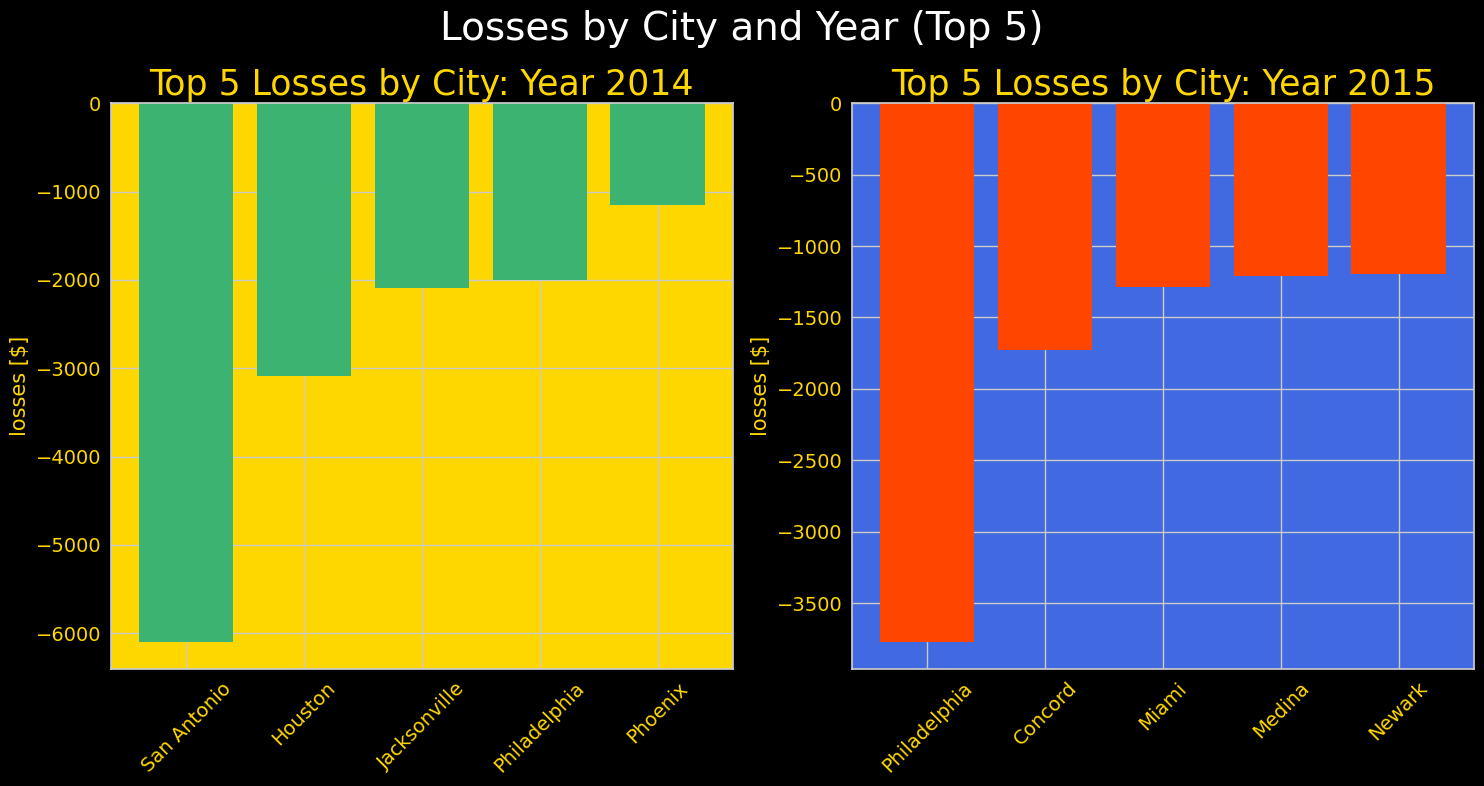

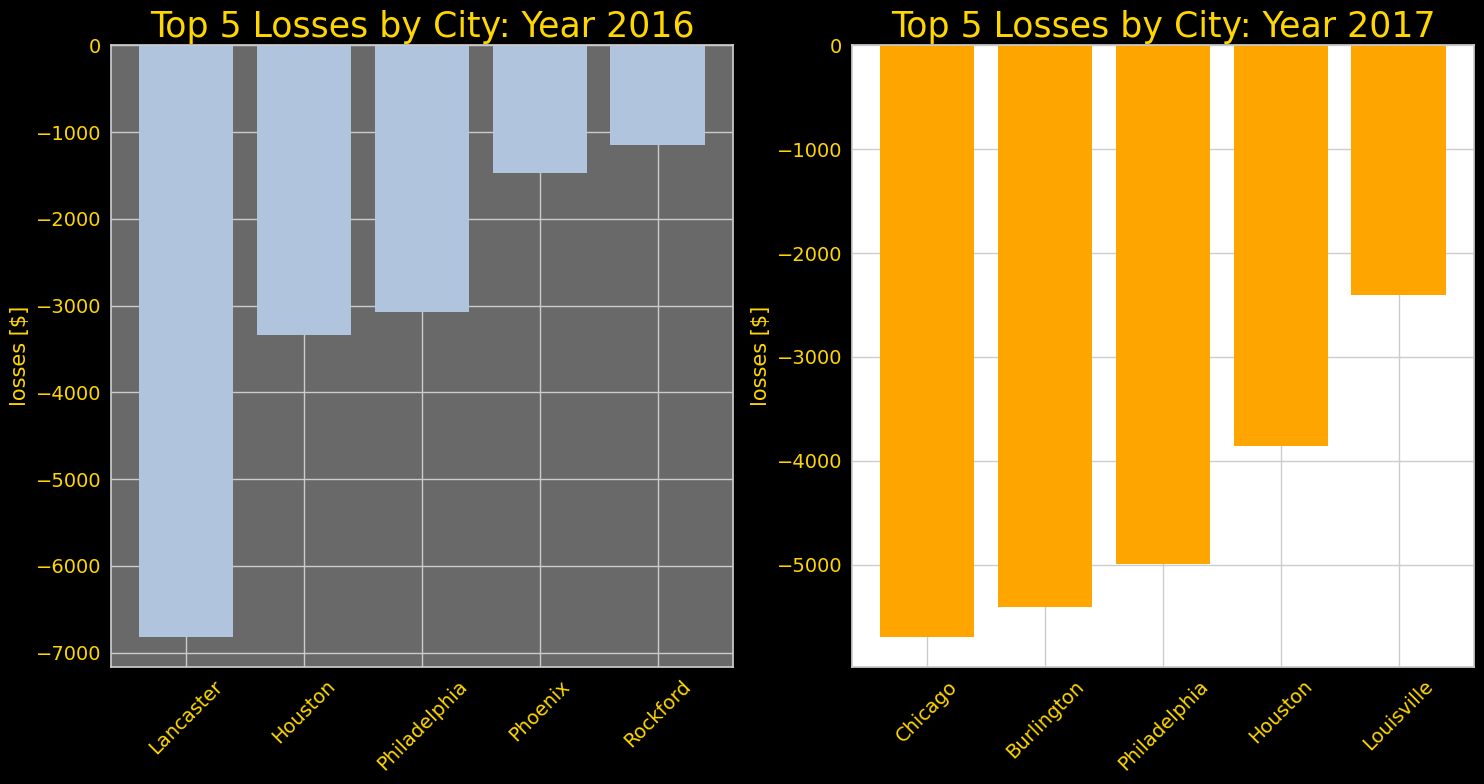

In [77]:
fig = plt.figure(figsize=(10,7));
(topfig,bottomfig) = fig.subfigures(2,1);

# Top figure
topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,2,figsize=(15,8));

axes[0].bar(x=least_profits_2014['City'],height=least_profits_2014['profits'],color='mediumseagreen');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,fontsize=14,color='gold');
axes[0].set_yticklabels(axes[0].get_yticklabels(),fontsize=14,color='gold');
axes[0].set_ylabel('losses [$]',fontsize=15,color='gold')
axes[0].set_title('Top 5 Losses by City: Year 2014',fontsize=25,color='gold');
axes[0].set_facecolor('gold')

axes[1].bar(x=least_profits_2015['City'],height=least_profits_2015['profits'],color='orangered');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,fontsize=14,color='gold');
axes[1].set_yticklabels(axes[1].get_yticklabels(),fontsize=14,color='gold');
axes[1].set_ylabel('losses [$]',fontsize=15,color='gold')
axes[1].set_title('Top 5 Losses by City: Year 2015',fontsize=25,color='gold');
axes[1].set_facecolor('royalblue')

fig.suptitle("Losses by City and Year (Top 5)",fontsize=28,color='white')
fig.set_facecolor('black')
plt.tight_layout()

# Bottom figure
bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4);
fig,axes = plt.subplots(1,2,figsize=(15,8));

axes[0].bar(x=least_profits_2016['City'],height=least_profits_2016['profits'],color='lightsteelblue');
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,fontsize=14,color='gold');
axes[0].set_yticklabels(axes[0].get_yticklabels(),fontsize=14,color='gold');
axes[0].set_ylabel('losses [$]',fontsize=15,color='gold')
axes[0].set_title('Top 5 Losses by City: Year 2016',fontsize=25,color='gold');
axes[0].set_facecolor('dimgrey')   

axes[1].bar(x=least_profits_2017['City'],height=least_profits_2017['profits'],color='orange');
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,fontsize=14,color='gold');
axes[1].set_yticklabels(axes[1].get_yticklabels(),fontsize=14,color='gold');
axes[1].set_ylabel('losses [$]',fontsize=15,color='gold')
axes[1].set_title('Top 5 Losses by City: Year 2017',fontsize=25,color='gold');
axes[1].set_facecolor('white')

fig.set_facecolor('black')
plt.tight_layout()

plt.tight_layout()
plt.show()

Some cities (like Philadelphia and Houston) are constantly in the chart of the worst 5 cities for losses. Superstore has to do something to solve this major issue.

<a id="4"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>4. Customer Behavior and Customer Segmentation</div></b>

### 4.1 Customer Segments

I want to get some more information about the customer segments (Consumer, Corporate or Home Office).

**Orders by Segment and Region**

In [78]:
orders_by_segment = data.groupby('Segment')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

orders_by_segment['count'].sum(), data['Order ID'].nunique()

(5009, 5009)

In [79]:
orders_by_region = data.groupby('Region')['Order ID'].nunique().reset_index(name='count').sort_values(['count'],ascending=False)

orders_by_region['count'].sum(), data['Order ID'].nunique()

(5009, 5009)

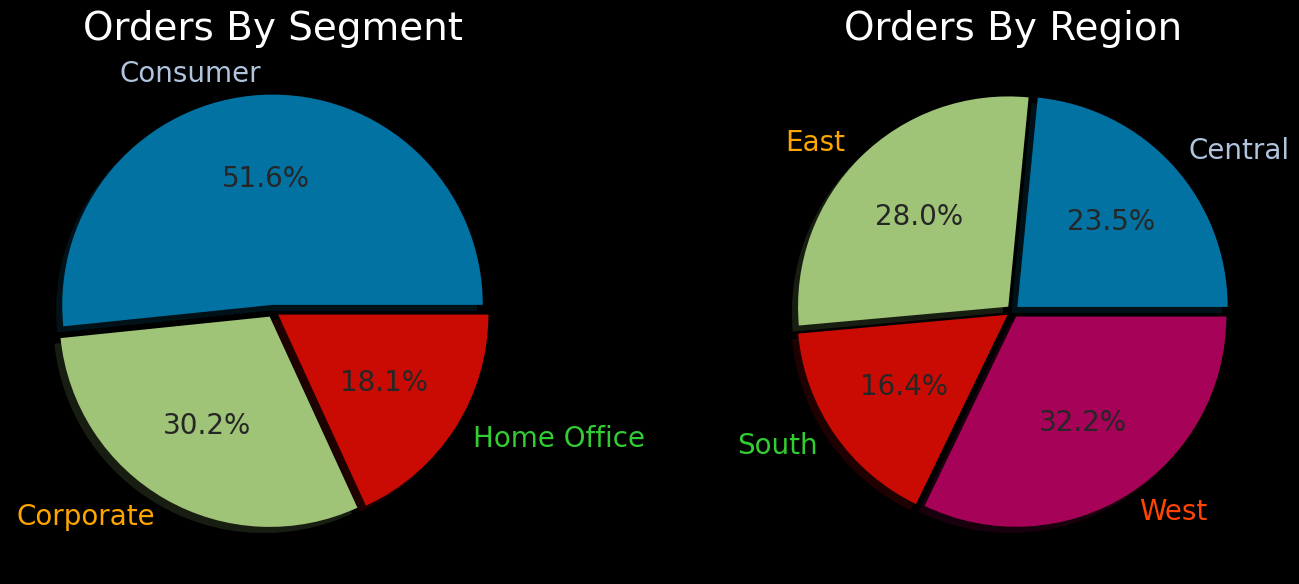

In [80]:
val = data.groupby('Segment')['Order ID'].nunique() # data.Segment.value_counts()
labels = ['Consumer','Corporate','Home Office']
colorlist = ['lightsteelblue','orange','limegreen']

val2 = data.groupby('Region')['Order ID'].nunique()
labels2 = ['Central','East','South','West']
colorlist2 = ['lightsteelblue','orange','limegreen','orangered']

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

# Plot #1
wedges,texts,auto = ax1.pie(val,labels=labels,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03))
ax1.set_title('Orders By Segment',color='white',fontsize=28)
for text,color in zip(texts,colorlist):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')

# Plot #2
wedges,texts,auto = ax2.pie(val2,labels=labels2,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03,0.03))
ax2.set_title('Orders By Region',color='white',fontsize=28)
for text,color in zip(texts,colorlist2):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')


plt.tight_layout()
plt.show()

In [81]:
segment_by_region = data.groupby(['Segment','Region'])['Quantity'].sum().reset_index(name='items sold').sort_values(['Segment','items sold'],ascending=False)

segment_by_region['items sold'].sum(), data['Quantity'].sum()

(37873, 37873)

In [82]:
segment_by_region['All'] = 'All'

fig = px.treemap(segment_by_region,path=['All','Segment','Region'],values='items sold',width=950,height=700);
fig.update_layout(title_text='Total Items Sold by Segment and Region',title_x=0.5,title_font=dict(size=25));
fig.update_layout(margin=dict(t=50,l=25,r=25,b=25),paper_bgcolor="black",font=dict(color="white",size=18));
fig.data[0].textinfo = 'label+value+percent parent'

plt.tight_layout();
fig.show();

<Figure size 800x550 with 0 Axes>

**Sales and Profits by Segment**

I want to have a look at the sales and profits by segment (consumer, corporate or home office).

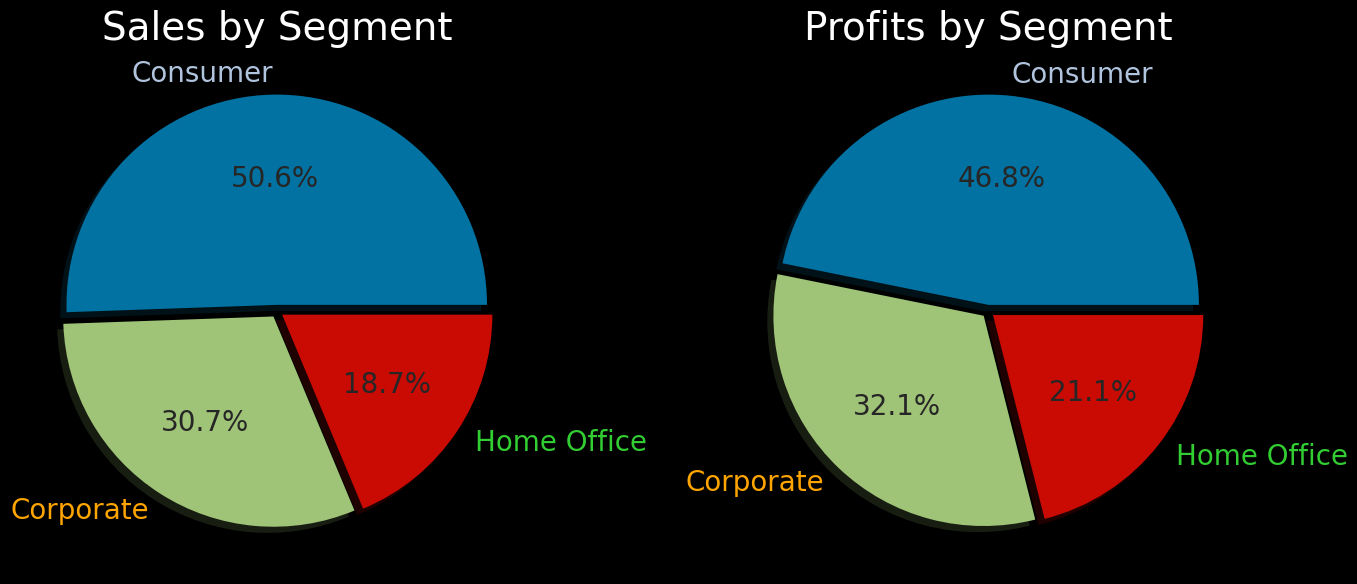

In [83]:
val = data.groupby('Segment')['Sales'].sum()
labels = ['Consumer','Corporate','Home Office']
colorlist = ['lightsteelblue','orange','limegreen']

val2 = data.groupby('Segment')['Profit'].sum()
labels2 = ['Consumer','Corporate','Home Office']

fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(14,6))

# Plot #1
wedges,texts,auto = ax1.pie(val,labels=labels,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03))
ax1.set_title('Sales by Segment',color='white',fontsize=28)
for text,color in zip(texts,colorlist):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')

# Plot #2
wedges,texts,auto = ax2.pie(val2,labels=labels2,autopct="%1.1f%%",textprops={'fontsize':20},
                                           shadow=True,explode=(0.03,0.03,0.03))
ax2.set_title('Profits by Segment',color='white',fontsize=28)
for text,color in zip(texts,colorlist):
    text.set_color(color)
    text.set_size(20)

fig.set_facecolor('black')


plt.tight_layout()
plt.show()

Around half of the sales and profits are due to consumers. The other half is given by corporate and home office sales.

### 4.2 Best and Worst Customers

Let's have a look at the customers who provided the highest profits and losses.

In [84]:
profits_by_customer = data.groupby('Customer ID')['Profit'].sum().reset_index(name='profits')

best_customers  = (profits_by_customer.sort_values(['profits'],ascending=False)).head(10)
worst_customers = (profits_by_customer.sort_values(['profits'],ascending=True)).head(10)

# Check
profits_by_customer['profits'].sum(), data['Profit'].sum()

(286397.02170000004, 286397.0217)

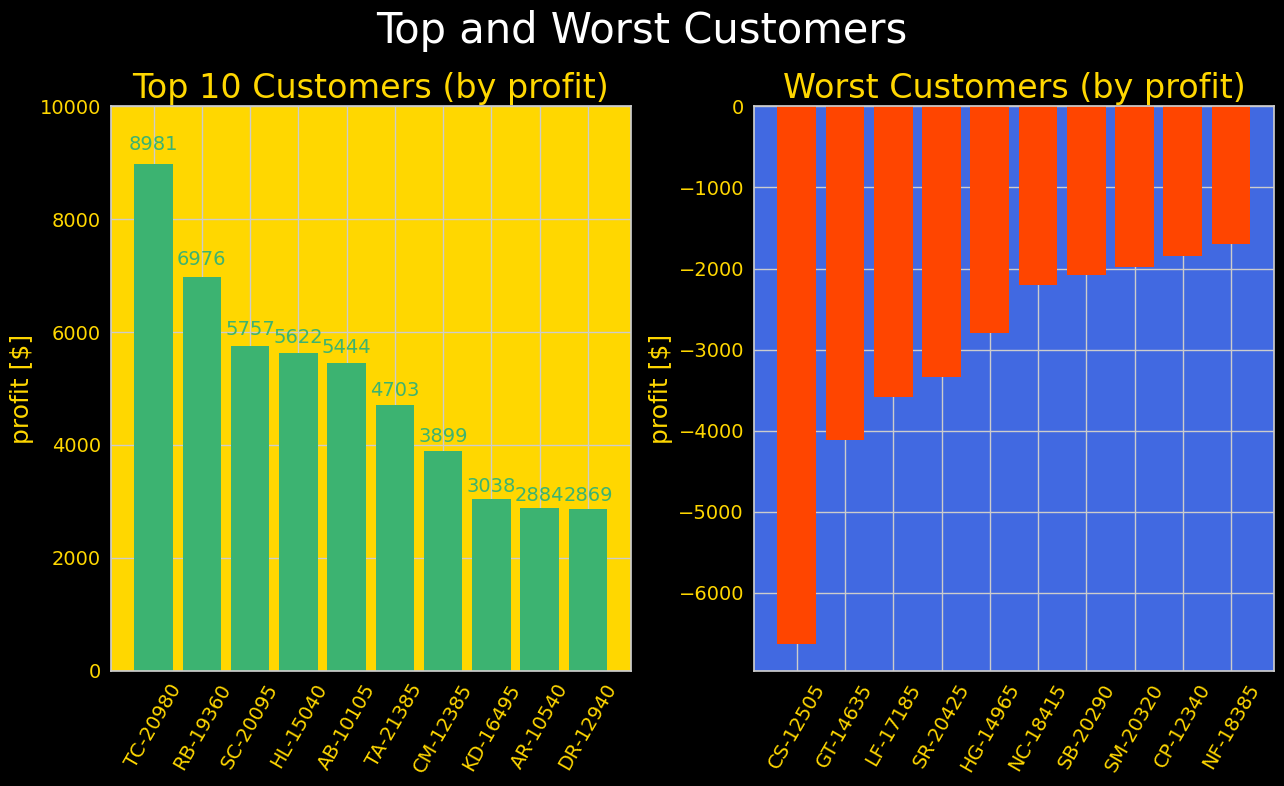

In [85]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,8))

### Plot #1 ###
fig1 = ax1.bar(best_customers['Customer ID'],best_customers['profits'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,10000])
ax1.set_title('Top 10 Customers (by profit)',fontsize=24,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('profit [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=60)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',14)

### Plot #2 ###
fig2 = ax2.bar(worst_customers['Customer ID'],worst_customers['profits'],color='orangered',linewidth=3)
#ax2.set_ylim([-60,15])
ax2.set_title('Worst Customers (by profit)',fontsize=24,color='gold')
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('profit [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=60)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
#autolabel(fig2,ax2,'orangered',16)

fig.suptitle("Top and Worst Customers",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

Then, I am plotting the cumulative sums of sales and profits.

In [86]:
total_profits = data['Profit'].sum()
cumulative_profits = (data.groupby('Customer ID')['Profit'].sum().sort_values(ascending=False)) / total_profits

total_sales = data['Sales'].sum()
cumulative_sales = (data.groupby('Customer ID')['Sales'].sum().sort_values(ascending=False)) / total_sales

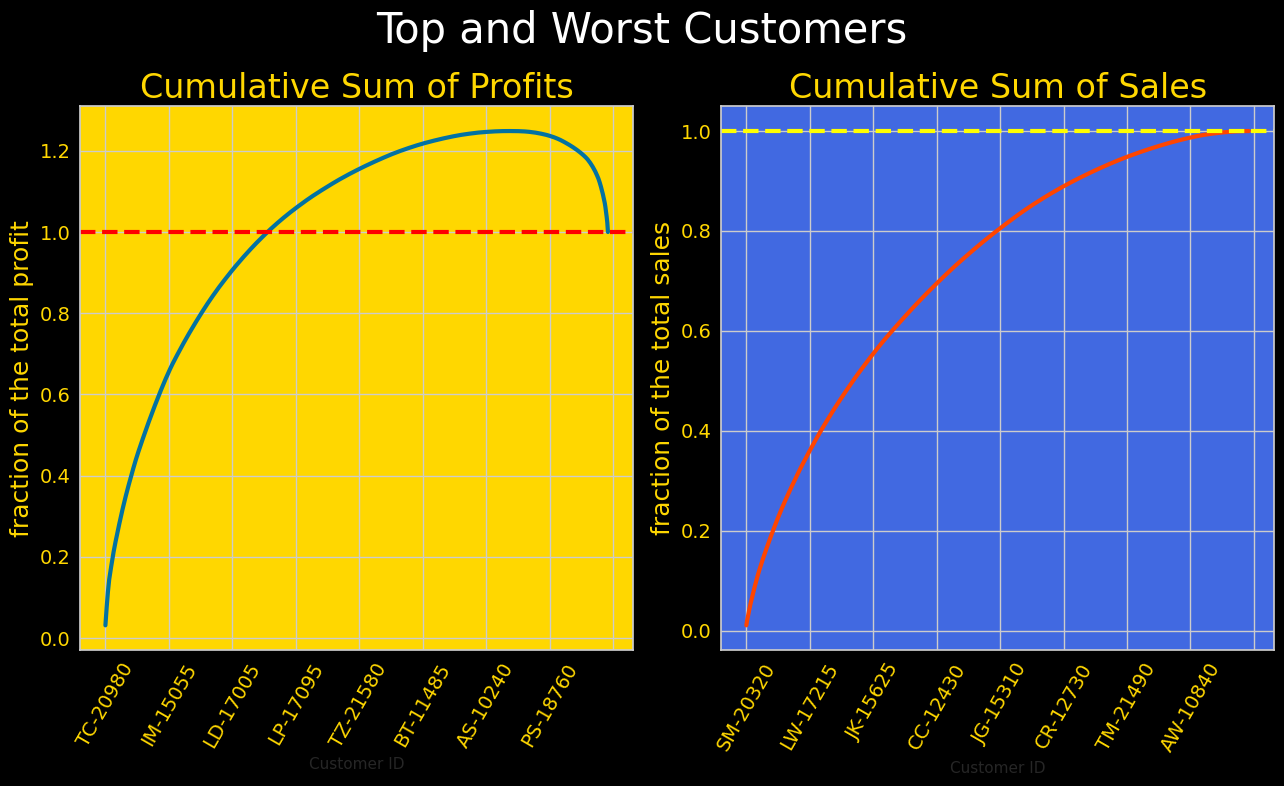

In [87]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(13,8))

### Plot #1 ###
fig1 = cumulative_profits.cumsum().plot(ax=ax1,linewidth=3)
ax1.axhline(y=1,color='red',linestyle='dashed',linewidth=3) 
ax1.set_title('Cumulative Sum of Profits',fontsize=24,color='gold')
ax1.xaxis.set_tick_params(labelsize=15,color='gold')
ax1.yaxis.set_tick_params(labelsize=15,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=15,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_ylabel('fraction of the total profit',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=60)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')

### Plot #2 ###
fig2 = cumulative_sales.cumsum().plot(ax=ax2,color='orangered',linewidth=3)
ax2.axhline(y=1,color='yellow',linestyle='dashed',linewidth=3) 
ax2.set_title('Cumulative Sum of Sales',fontsize=24,color='gold')
ax2.xaxis.set_tick_params(labelsize=15,color='gold')
ax2.yaxis.set_tick_params(labelsize=15,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=15,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_ylabel('fraction of the total sales',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=60)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')

fig.suptitle("Top and Worst Customers",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

One can notice that:
- The profit curve grows much faster in its first part. This means that there are customers that grant higher profits with respect to all the others.
- The profit curve grows larger than 1 (100% of the profit, red-dashed line) and then it goes back to 1. This is because there are many customers that provide negative profits and they are all in the second part of the curve.

<a id="5"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>5. Cluster Analysis and Customer Personas</div></b>

### 5.1 Introducing a New Feature (Customer Recency) and Dropping Some Columns

I am introducing a new feature (*customer recency*), that can help in the clustering process.

The first step is to get the minimum and maximum 'dates' in the dataset.

In [88]:
min_date = min(data['Order Date'])
max_date = max(data['Order Date'])

min_date, max_date

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

Then, I am defining for each customer the *last purchase date* and the *customer recency* (i.e. the number of days before the last purchase).

In [89]:
data['Last Purchase Date'] = data.groupby('Customer ID')['Order Date'].transform(max)
data['Last Purchase Date'] = pd.to_datetime(data['Last Purchase Date']) # .dt.date

data["Customer Recency"] = (data["Order Date"] - data["Last Purchase Date"]).dt.days

Finally, I am dropping some columns that might be unnecessary in the cluster analysis.

In [90]:
customer_data = data.copy()

customer_data.drop(['Order ID','Order Date','Ship Date','Product Name','year','month',
                    'day','order ship time','Last Purchase Date','Sub-Category'],
                  axis=1,inplace=True)

customer_data.head()

,Ship Mode,Customer ID,Segment,City,State,Region,Category,Sales,Quantity,Discount,Profit,Customer Recency
0,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,261.9600,2,0.00,41.9136,-79
1,Second Class,CG-12520,Consumer,Henderson,Kentucky,South,Furniture,731.9400,3,0.00,219.5820,-79
2,Second Class,DV-13045,Corporate,Los Angeles,California,West,Office Supplies,14.6200,2,0.00,6.8714,-547
3,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Furniture,957.5775,5,0.45,-383.0310,-782
4,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,South,Office Supplies,22.3680,2,0.20,2.5164,-782


### 5.2 K-Means Method

#### 5.2.1 Label Encoding and Scaling

In [91]:
### Label encoding ###
LABELS = customer_data.columns

encoder = LabelEncoder()

for col in LABELS:
    # Check if object
    if customer_data[col].dtype == 'O':
        # Fit label encoder and return encoded labels
        customer_data[col] = encoder.fit_transform(customer_data[col])   

In [92]:
### Scaling ###
mm_scaler = MinMaxScaler() 

# Apply Min-Max Scaling
customer_data[LABELS] = mm_scaler.fit_transform(customer_data[LABELS])

customer_data.head()

,Ship Mode,Customer ID,Segment,City,State,Region,Category,Sales,Quantity,Discount,Profit,Customer Recency
0,0.666667,0.180556,0.0,0.366038,0.312500,0.666667,0.0,0.011552,0.076923,0.0000,0.442794,0.945139
1,0.666667,0.180556,0.0,0.366038,0.312500,0.666667,0.0,0.032313,0.153846,0.0000,0.454639,0.945139
2,0.666667,0.299242,0.5,0.501887,0.062500,1.000000,0.5,0.000626,0.076923,0.0000,0.440458,0.620139
3,1.000000,0.890152,0.0,0.288679,0.166667,0.666667,0.0,0.042280,0.307692,0.5625,0.414464,0.456944
4,1.000000,0.890152,0.0,0.288679,0.166667,0.666667,0.5,0.000968,0.076923,0.2500,0.440168,0.456944


#### 5.2.2 Dimensionality Reduction (with PCA)

[ 20.48  35.6   49.57  59.92  68.74  77.29  85.57  91.89  96.87  99.9
  99.98 100.  ]


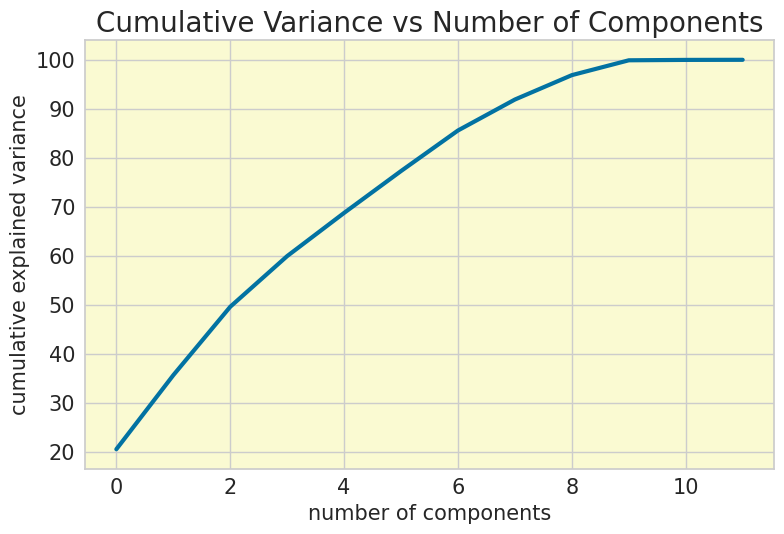

In [93]:
pca = PCA(n_components=12)
pca.fit(customer_data) 

# The amount of variance that each PC explains
var = pca.explained_variance_ratio_

# Cumulative Variance explains
var = np.cumsum(np.round(pca.explained_variance_ratio_,decimals=4)*100)
print(var)

plt.plot(var,linewidth=3)
plt.xlabel('number of components',fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('cumulative explained variance',fontsize=15)
plt.yticks(fontsize=15)
plt.title('Cumulative Variance vs Number of Components',fontsize=20) #,color='white')

plt.tight_layout()
plt.gca().set_facecolor('lightgoldenrodyellow')
plt.show()

Considering N = 8 dimensions, I can explain more than 90% of the total variance.

In [94]:
# Initiating PCA to reduce dimentions to 8
pca = PCA(n_components=8)
pca.fit(customer_data) 
PCA_CD = pd.DataFrame(pca.transform(customer_data),columns=(["col1","col2","col3","col4","col5",
                                                    "col6","col7","col8"]))
PCA_CD.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,9994.0,-3.839234e-17,0.444549,-0.741287,-0.377668,0.116388,0.329589,0.903361
col2,9994.0,-7.465178e-18,0.381948,-0.413742,-0.333128,-0.246243,0.193531,0.778568
col3,9994.0,1.372171e-16,0.367224,-0.406096,-0.261553,-0.205509,0.116751,0.869915
col4,9994.0,0.000000e+00,0.316061,-0.611777,-0.067085,-0.017693,0.074924,0.645682
col5,9994.0,8.158373e-17,0.291696,-0.819667,-0.212613,-0.004694,0.207502,0.919584
col6,9994.0,-3.625944e-17,0.287261,-0.853800,-0.197328,-0.005159,0.186894,0.913895
col7,9994.0,3.128265e-17,0.282764,-0.744038,-0.210880,-0.018160,0.197118,0.948072
col8,9994.0,-2.132908e-18,0.247049,-0.501914,-0.163799,-0.038325,0.115867,0.858639


#### 5.2.3 Clustering

Now, I will define the clusters of customers by using the 'k-means' algorithm. To decide the proper number of clusters, I will first make use of the **elbow method**.

In [95]:
inertia = []
for i in range(1,10):
    kmeans = KMeans(n_clusters=i,init='k-means++',random_state=42)
    # k-means++ is an algorithm for choosing the initial values (or "seeds") for the k-means clustering algorithm.
    kmeans.fit(PCA_CD)
    inertia.append(kmeans.inertia_)

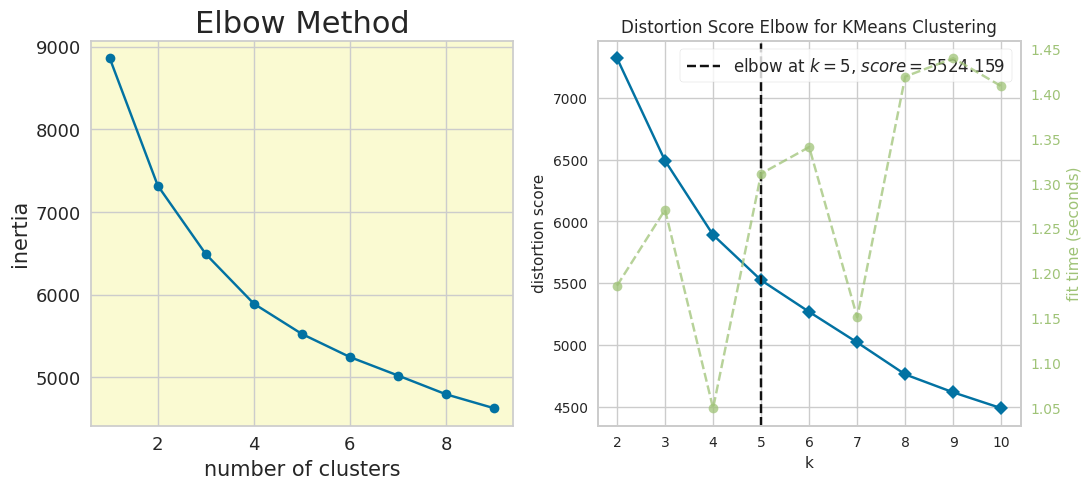

<Figure size 800x550 with 0 Axes>

In [96]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1.plot(range(1,10),inertia,marker='o',linestyle='-')
ax1.xaxis.set_tick_params(labelsize=13)
ax1.yaxis.set_tick_params(labelsize=13)
ax1.set_facecolor('lightgoldenrodyellow')
ax1.set_xlabel("number of clusters",fontsize=15)
ax1.set_ylabel('inertia',fontsize=15)
ax1.set_title("Elbow Method",fontsize=22)

# Second Plot
Elbow_M = KElbowVisualizer(KMeans(),k=10)
Elbow_M.fit(PCA_CD)
ax2 = Elbow_M.show()

plt.tight_layout() 

According to the elbow method, the best number of clusters is n = 5.

I am calculating the **silhouette score**.

In [97]:
silhouette_scores = []

range_clusters = range(2,11)
for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=0)
    labels = kmeans.fit_predict(PCA_CD) 
    score = silhouette_score(PCA_CD,labels)
    silhouette_scores.append(score)

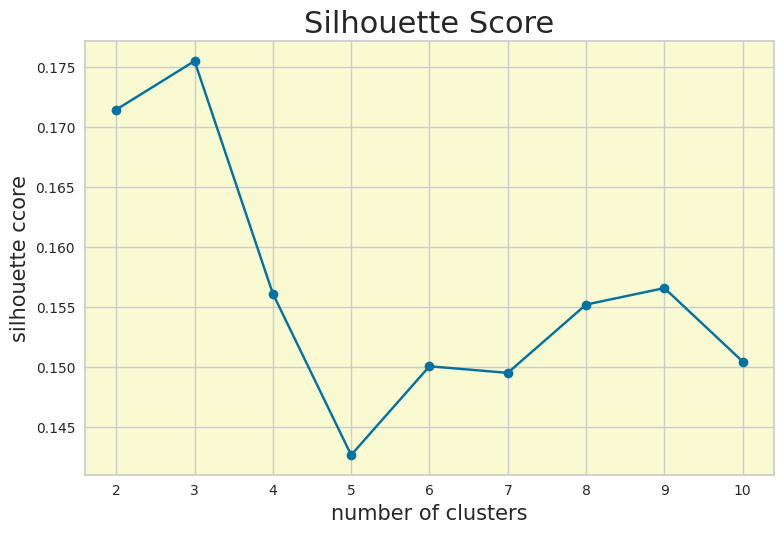

In [98]:
plt.plot(range_clusters,silhouette_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('silhouette ccore',fontsize=15)
plt.title("Silhouette Score",fontsize=22)

plt.tight_layout()
plt.gca().set_facecolor('lightgoldenrodyellow')
plt.show()

The silhouette score is higher for $n_{\rm clusters}$ = 3.

Then, I will perform a silhouette analysis.

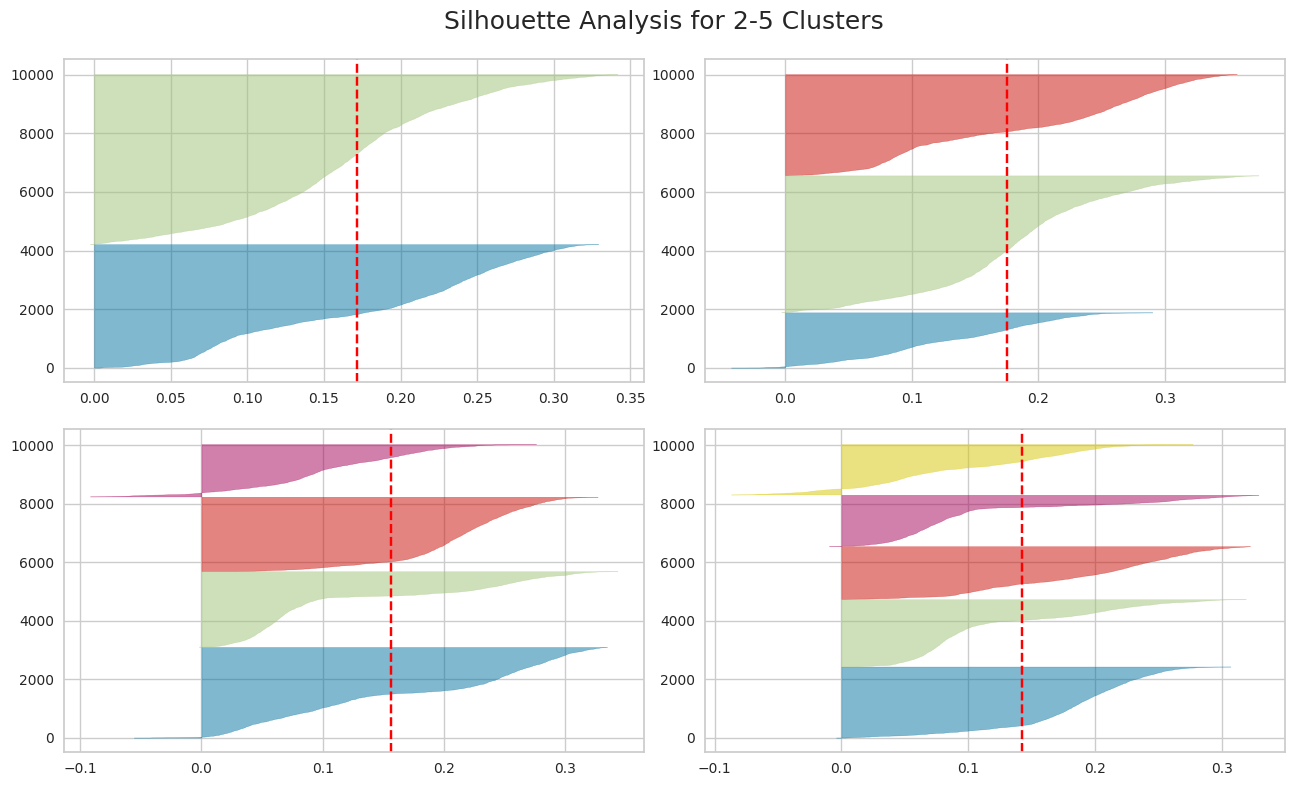

In [99]:
fig,ax = plt.subplots(2,2,figsize=(13,8))
fig.suptitle('Silhouette Analysis for 2-5 Clusters',size=18)
plt.tight_layout()

for i in [2,3,4,5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=100,random_state=42)
    q,mod = divmod(i,2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer=SilhouetteVisualizer(km,colors='yellowbrick',ax=ax[q-1][mod])
    visualizer.fit(PCA_CD)

One can notice that:
- There is presence of clusters with below average silhouette scores for 2 and 5-cluster cases.
- Accoring to these plots, one should choose between the 3 and 4-cluster cases.
- If we combine these results with those of the previous plot, we can conclude that the most favorable case is that of $n_{\rm clusters}$ = 3.

Finally, I will calculate the **Davies-Bouldin score**.

In [100]:
davies_bouldin_scores = []

for i in range_clusters:
    kmeans = KMeans(n_clusters=i,random_state=0)
    labels = kmeans.fit_predict(PCA_CD)
    score = davies_bouldin_score(PCA_CD,labels)
    davies_bouldin_scores.append(score)

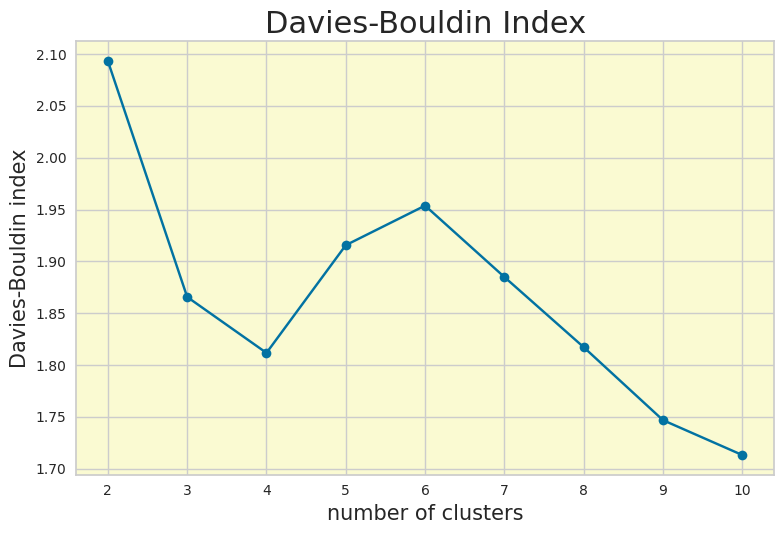

In [101]:
plt.plot(range_clusters,davies_bouldin_scores,marker='o')
plt.xlabel("number of clusters",fontsize=15)
plt.ylabel('Davies-Bouldin index',fontsize=15)
plt.title("Davies-Bouldin Index",fontsize=22)

plt.tight_layout()
plt.gca().set_facecolor('lightgoldenrodyellow')
plt.show()

For $n_{\rm clusters}$ < 8, the plot shows that the lowest Davies-Bouldin value occurs at 4 clusters, suggesting that the optimal number of clusters is four.

In conclusion, based on the results of the elbow method, the silhouette score and the Davies-Bouldin index, **the optimal number of clusters is between 3 and 5.**

#### 5.2.4 Agglomerative Clustering model

In [102]:
# Initiating the Agglomerative Clustering model. n_clusters = 3, Euclidean metric case
AC = AgglomerativeClustering(n_clusters=3)

# Fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_CD)
PCA_CD["Clusters 3"] = yhat_AC

# Adding the Clusters feature to the original and scaled dataframes
data["Clusters 3"] = yhat_AC
customer_data["Clusters 3"] = yhat_AC

In [103]:
# Initiating the Agglomerative Clustering model. n_clusters = 4, Euclidean metric case
AC = AgglomerativeClustering(n_clusters=4)

# Fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_CD)
PCA_CD["Clusters 4"] = yhat_AC

# Adding the Clusters feature to the original and scaled dataframes
data["Clusters 4"] = yhat_AC
customer_data["Clusters 4"] = yhat_AC

Also the original dataframe has new 'Clusters 3' and 'Clusters 4' features.

**Group Distribution of Clusters**

We want to see how the clusters' populations are (numerically) distributed.

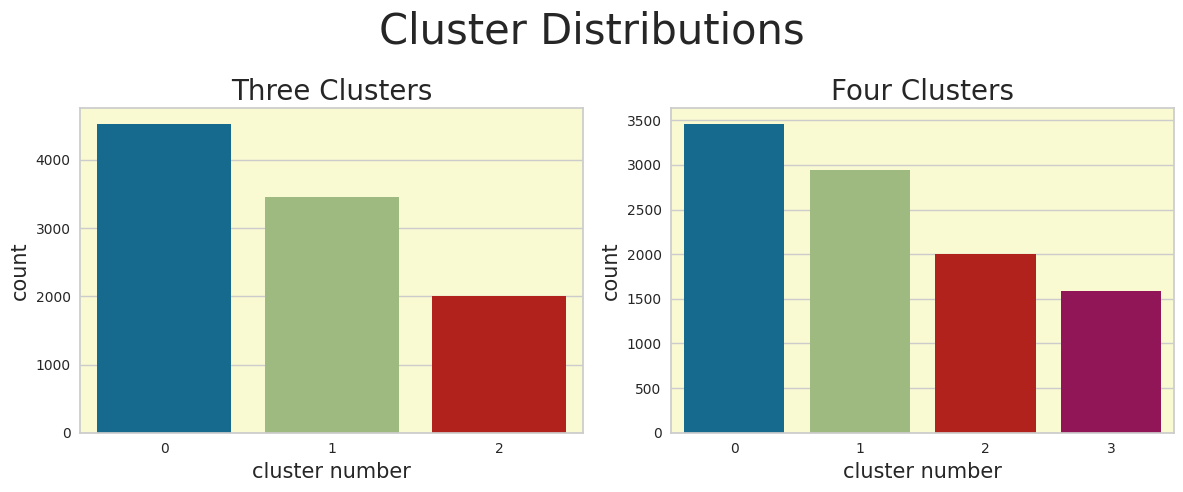

In [104]:
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12,5))

# First Plot
ax1 = sns.countplot(x=data["Clusters 3"],ax=ax1)
ax1.set_facecolor('lightgoldenrodyellow')
ax1.set_xlabel("cluster number",fontsize=15)
ax1.set_ylabel('count',fontsize=15)
ax1.set_title("Three Clusters",fontsize=20)

# Second Plot
ax2 = sns.countplot(x=data["Clusters 4"],ax=ax2)
ax2.set_facecolor('lightgoldenrodyellow')
ax2.set_xlabel("cluster number",fontsize=15)
ax2.set_ylabel('count',fontsize=15)
ax2.set_title("Four Clusters",fontsize=20)

fig.suptitle("Cluster Distributions",fontsize=30)

plt.tight_layout() 

#### 5.2.5 First Case: Three Clusters

Now, I am having a look at the distributions of the variables by cluster content.

In [105]:
avg_sales_clusters = data.groupby('Clusters 3')['Sales'].mean().reset_index(name='average sales').sort_values(['average sales'],ascending=False)

avg_profit_clusters = data.groupby('Clusters 3')['Profit'].mean().reset_index(name='average profit').sort_values(['average profit'],ascending=False)

avg_discount_clusters = (data.groupby('Clusters 3')['Discount'].mean() * 100).reset_index(name='average discount').sort_values(['average discount'],ascending=False)

avg_discount_clusters

,Clusters 3,average discount
0,0,19.162878
2,2,16.232268
1,1,10.628431


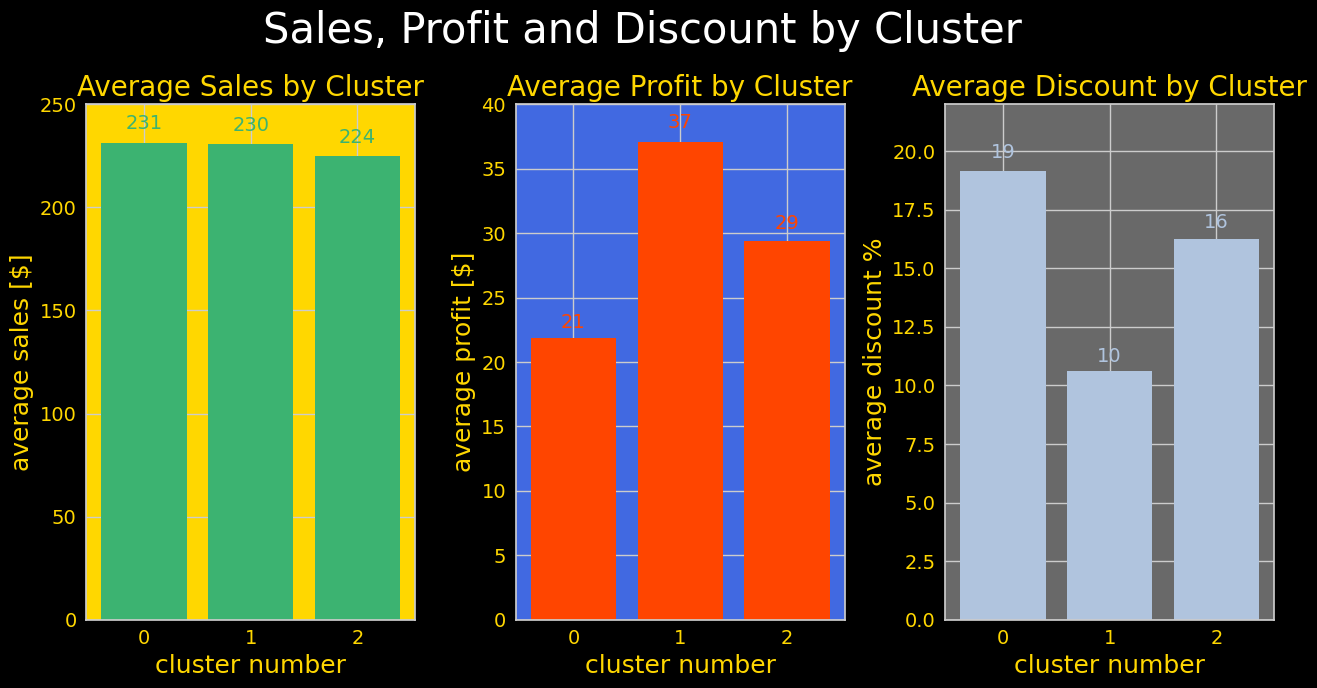

In [106]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(13,7))

### Plot #1 ###
fig1 = ax1.bar(avg_sales_clusters['Clusters 3'],avg_sales_clusters['average sales'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,250])
ax1.set_title('Average Sales by Cluster',fontsize=20,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_xlabel('cluster number',fontsize=18,color='gold')
ax1.set_ylabel('average sales [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',14)

### Plot #2 ###
fig2 = ax2.bar(avg_profit_clusters['Clusters 3'],avg_profit_clusters['average profit'],linewidth=3,color='orangered')
ax2.set_ylim([0,40])
ax2.set_title('Average Profit by Cluster',fontsize=20,color='gold')
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_xlabel('cluster number',fontsize=18,color='gold')
ax2.set_ylabel('average profit [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',14)

### Plot #3 ###
fig3 = ax3.bar(avg_discount_clusters['Clusters 3'],avg_discount_clusters['average discount'],linewidth=3,color='lightsteelblue')
ax3.set_ylim([0,22])
ax3.set_title('Average Discount by Cluster',fontsize=20,color='gold')
ax3.xaxis.set_tick_params(labelsize=13,color='gold')
ax3.yaxis.set_tick_params(labelsize=13,color='gold')
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=12,color='gold')
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=10,color='gold')
ax3.set_xlabel('cluster number',fontsize=18,color='gold')
ax3.set_ylabel('average discount %',fontsize=18,color='gold')
ax3.yaxis.set_tick_params(labelsize=14)
ax3.xaxis.set_tick_params(labelsize=14)
ax3.set_facecolor('dimgrey')
autolabel(fig3,ax3,'lightsteelblue',14)

fig.suptitle("Sales, Profit and Discount by Cluster",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

One can notice that:
- The average sales are almost the same within the three clusters.
- On the contrary, in the case of profit there is a clear difference between the three clusters.
- The clear difference between clusters appears in the discount case too.

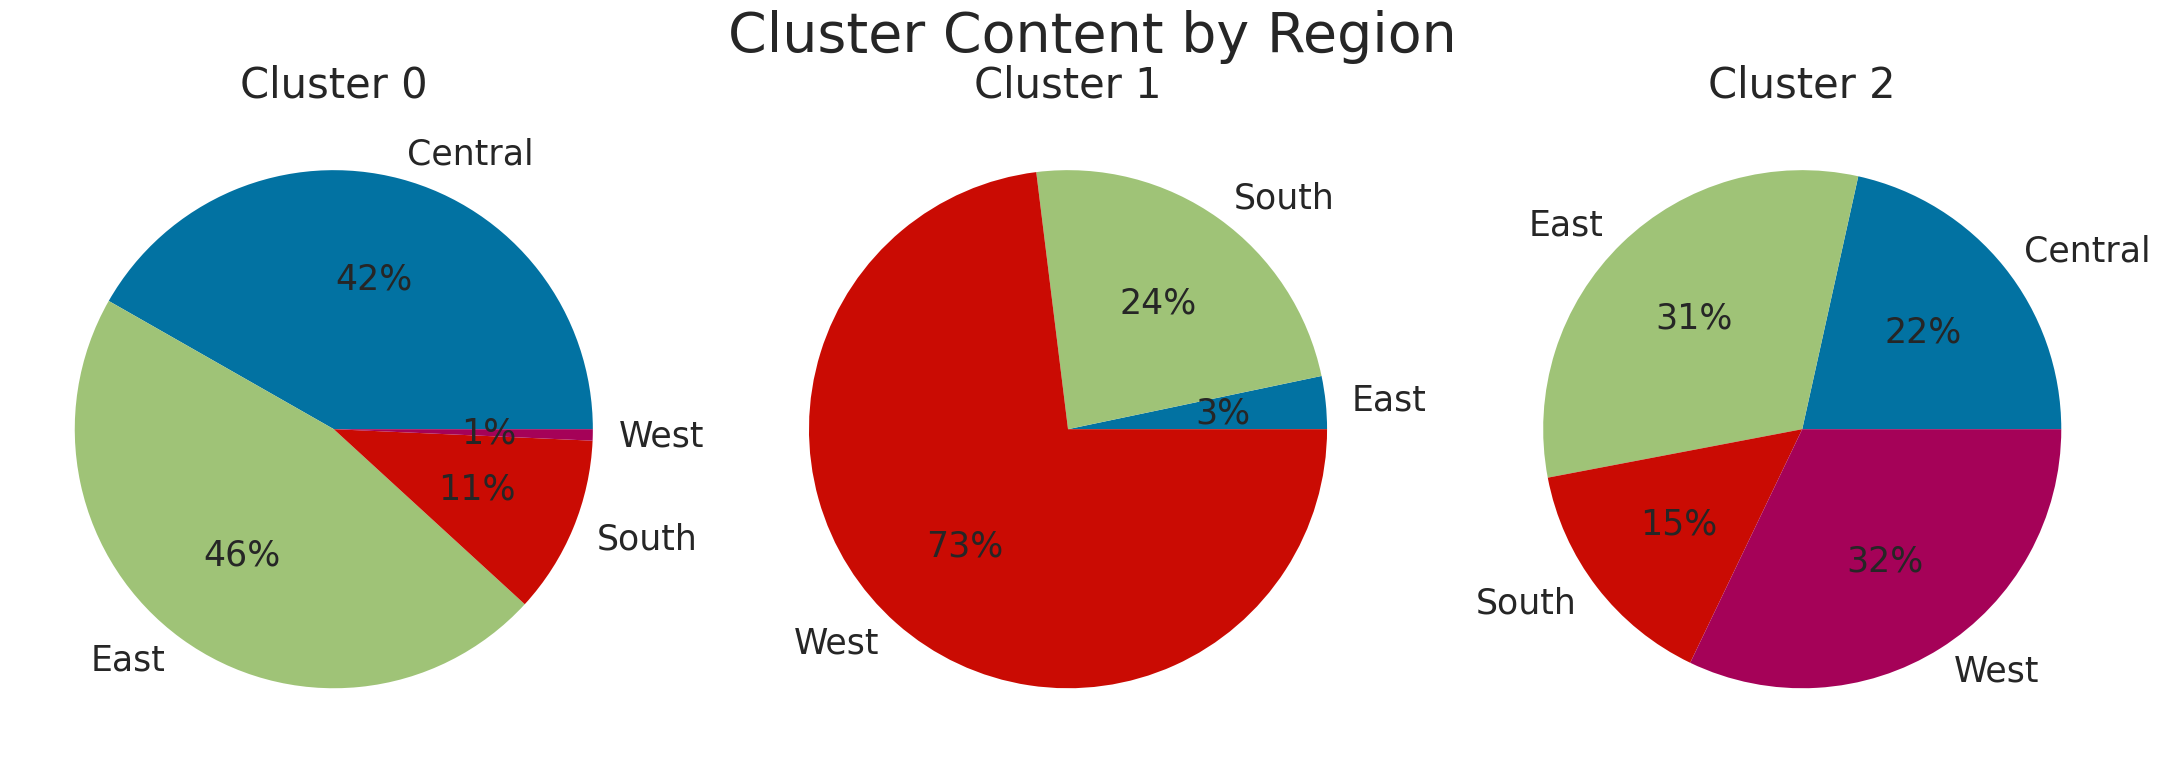

In [107]:
def label_function(val):
    return f'{val:.0f}%'

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(22,8))

data[data['Clusters 3'] == 0].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax1)
data[data['Clusters 3'] == 1].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax2)
data[data['Clusters 3'] == 2].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax3)

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)

fig.suptitle("Cluster Content by Region",fontsize=40)
plt.tight_layout()

plt.show()

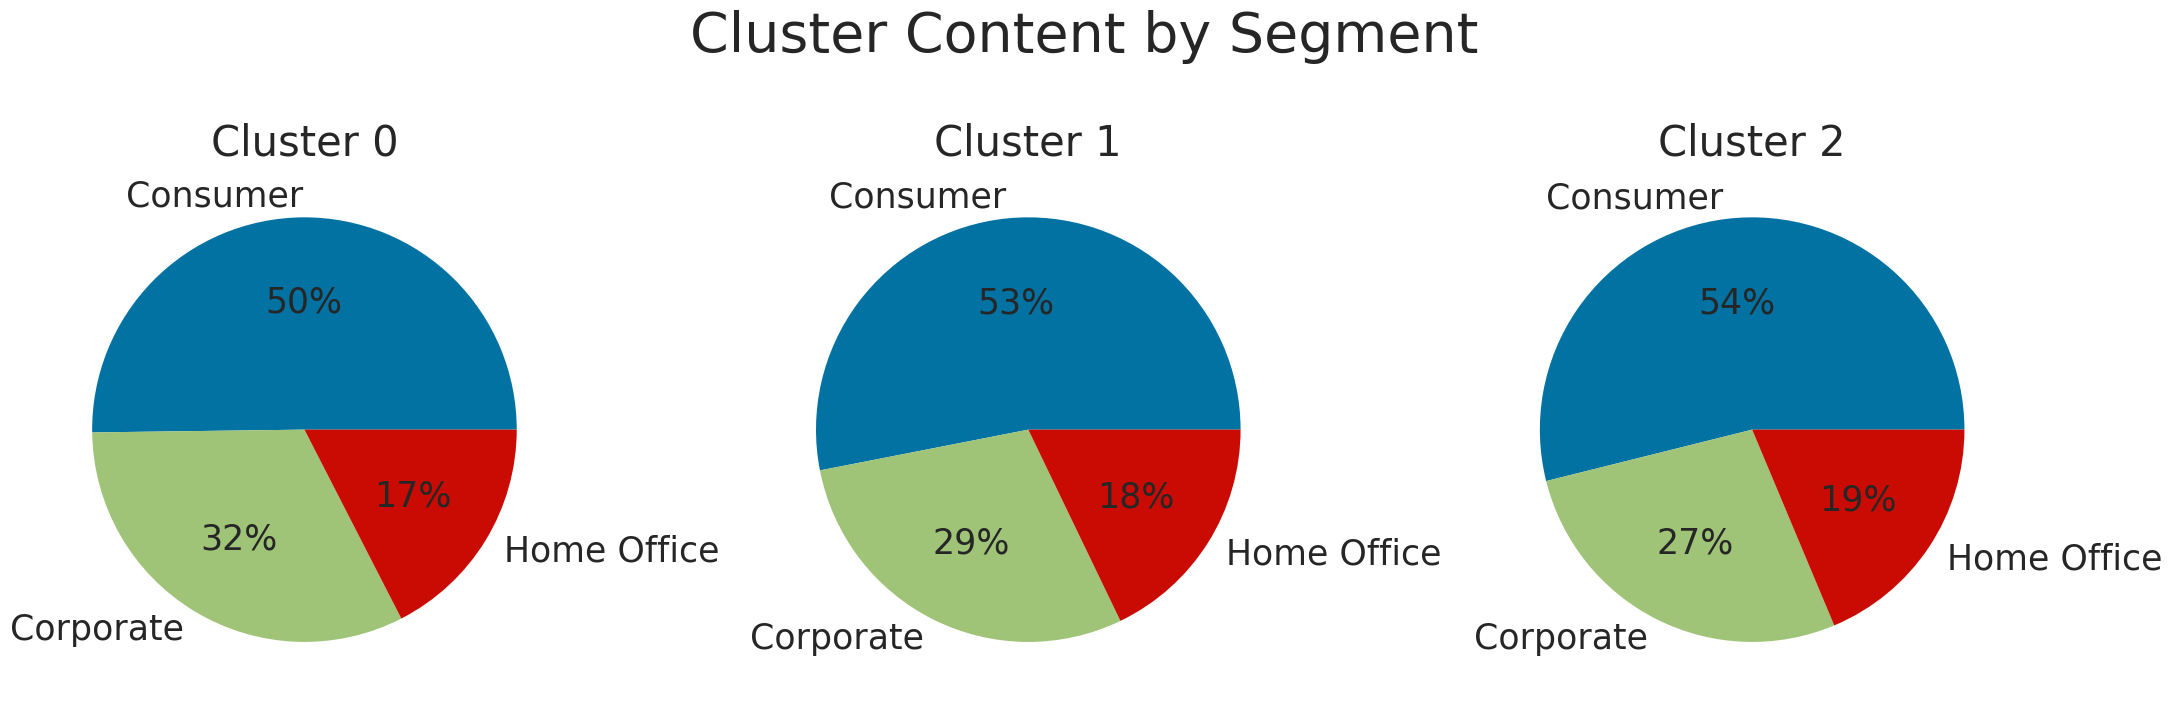

In [108]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(22,8))

data[data['Clusters 3'] == 0].groupby('Segment').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax1)
data[data['Clusters 3'] == 1].groupby('Segment').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax2)
data[data['Clusters 3'] == 2].groupby('Segment').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':25},ax=ax3)

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)

fig.suptitle("Cluster Content by Segment",fontsize=40)
plt.tight_layout()

plt.show()

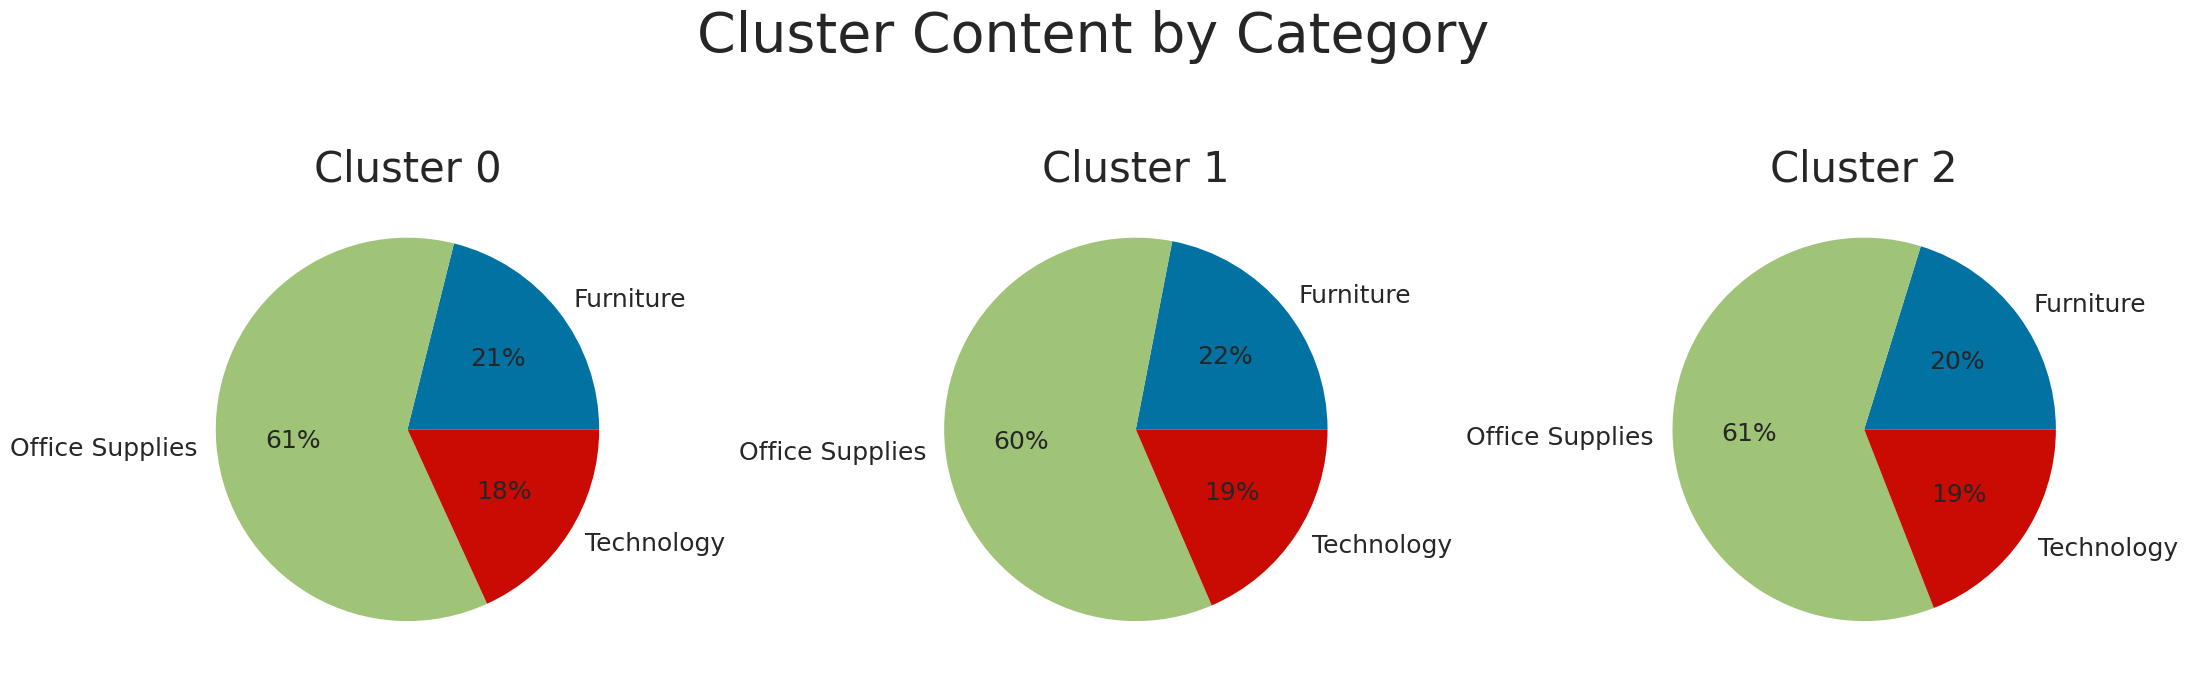

In [109]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(22,8))

data[data['Clusters 3'] == 0].groupby('Category').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax1)
data[data['Clusters 3'] == 1].groupby('Category').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax2)
data[data['Clusters 3'] == 2].groupby('Category').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax3)

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)

fig.suptitle("Cluster Content by Category",fontsize=40)
plt.tight_layout()

plt.show()

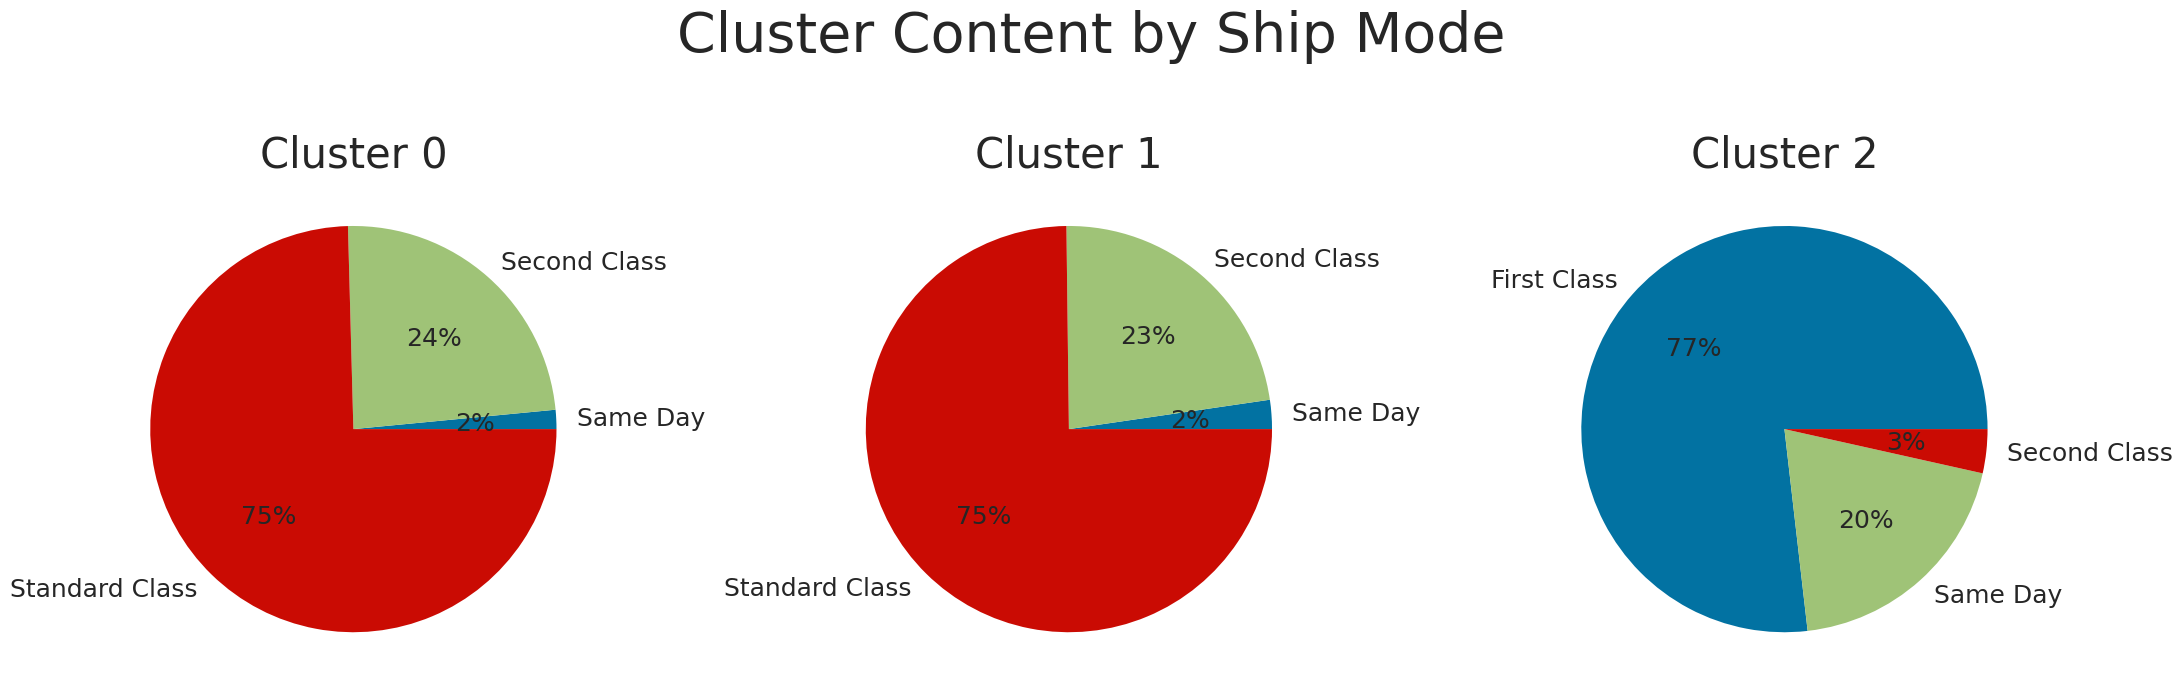

In [110]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(22,8))

data[data['Clusters 3'] == 0].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax1)
data[data['Clusters 3'] == 1].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax2)
data[data['Clusters 3'] == 2].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':18},ax=ax3)

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)

fig.suptitle("Cluster Content by Ship Mode",fontsize=40)
plt.tight_layout()

plt.show()

**Customer Personas**

I am creating a customer persona for each cluster based on the average values of the features. Customer personas are fictitious characters that embody different categories of customers.

In [111]:
table_data = [['Cluster Number','Customer Persona','Profit','Discount','Ship Mode','Region','Customer value'],
             ['Cluster 0','Greedy Albert','Low','High','Standard Class','Everywhere in the US','**'],
             ['Cluster 1','Shopaholic Carlie','High','Low','Standard Class','West','****'],
             ['Cluster 2','Average Billy','Medium','Medium','First Class','Everywhere in the US','***']]

# Initialize a figure with FF.create_table(table_data)
figure = FF.create_table(table_data,height_constant=30)
figure.layout.width=1000

iplot(figure)

#### 5.2.6 Second Case: Four Clusters

In [112]:
avg_sales_clusters = data.groupby('Clusters 4')['Sales'].mean().reset_index(name='average sales').sort_values(['average sales'],ascending=False)

avg_profit_clusters = data.groupby('Clusters 4')['Profit'].mean().reset_index(name='average profit').sort_values(['average profit'],ascending=False)

avg_discount_clusters = (data.groupby('Clusters 4')['Discount'].mean() * 100).reset_index(name='average discount').sort_values(['average discount'],ascending=False)

avg_discount_clusters

,Clusters 4,average discount
1,1,23.892433
2,2,16.232268
0,0,10.628431
3,3,10.363636


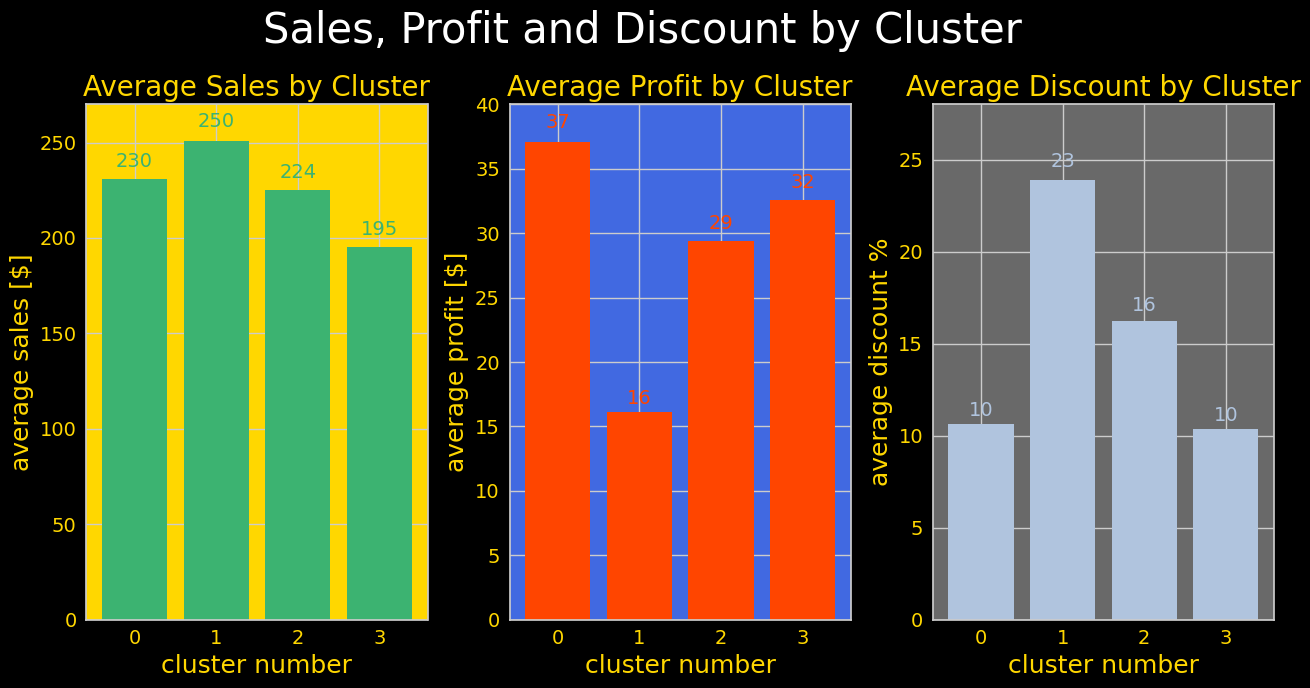

In [113]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(13,7))

### Plot #1 ###
fig1 = ax1.bar(avg_sales_clusters['Clusters 4'],avg_sales_clusters['average sales'],linewidth=3,color='mediumseagreen')
ax1.set_ylim([0,270])
ax1.set_title('Average Sales by Cluster',fontsize=20,color='gold')
ax1.xaxis.set_tick_params(labelsize=13,color='gold')
ax1.yaxis.set_tick_params(labelsize=13,color='gold')
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=12,color='gold')
ax1.set_yticklabels(ax1.get_yticklabels(),fontsize=10,color='gold')
ax1.set_xlabel('cluster number',fontsize=18,color='gold')
ax1.set_ylabel('average sales [$]',fontsize=18,color='gold')
ax1.yaxis.set_tick_params(labelsize=14)
ax1.xaxis.set_tick_params(labelsize=14)
ax1.set_facecolor('gold')
autolabel(fig1,ax1,'mediumseagreen',14)

### Plot #2 ###
fig2 = ax2.bar(avg_profit_clusters['Clusters 4'],avg_profit_clusters['average profit'],linewidth=3,color='orangered')
ax2.set_ylim([0,40])
ax2.set_title('Average Profit by Cluster',fontsize=20,color='gold')
ax2.xaxis.set_tick_params(labelsize=13,color='gold')
ax2.yaxis.set_tick_params(labelsize=13,color='gold')
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=12,color='gold')
ax2.set_yticklabels(ax2.get_yticklabels(),fontsize=10,color='gold')
ax2.set_xlabel('cluster number',fontsize=18,color='gold')
ax2.set_ylabel('average profit [$]',fontsize=18,color='gold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.xaxis.set_tick_params(labelsize=14)
ax2.set_facecolor('royalblue')
autolabel(fig2,ax2,'orangered',14)

### Plot #3 ###
fig3 = ax3.bar(avg_discount_clusters['Clusters 4'],avg_discount_clusters['average discount'],linewidth=3,color='lightsteelblue')
ax3.set_ylim([0,28])
ax3.set_title('Average Discount by Cluster',fontsize=20,color='gold')
ax3.xaxis.set_tick_params(labelsize=13,color='gold')
ax3.yaxis.set_tick_params(labelsize=13,color='gold')
ax3.set_xticklabels(ax3.get_xticklabels(),fontsize=12,color='gold')
ax3.set_yticklabels(ax3.get_yticklabels(),fontsize=10,color='gold')
ax3.set_xlabel('cluster number',fontsize=18,color='gold')
ax3.set_ylabel('average discount %',fontsize=18,color='gold')
ax3.yaxis.set_tick_params(labelsize=14)
ax3.xaxis.set_tick_params(labelsize=14)
ax3.set_facecolor('dimgrey')
autolabel(fig3,ax3,'lightsteelblue',14)

fig.suptitle("Sales, Profit and Discount by Cluster",fontsize=30,color='white')
fig.set_facecolor('black')
plt.tight_layout()

As in the 3-cluster case, there is a clear difference in the distribution of the variables within the clusters.

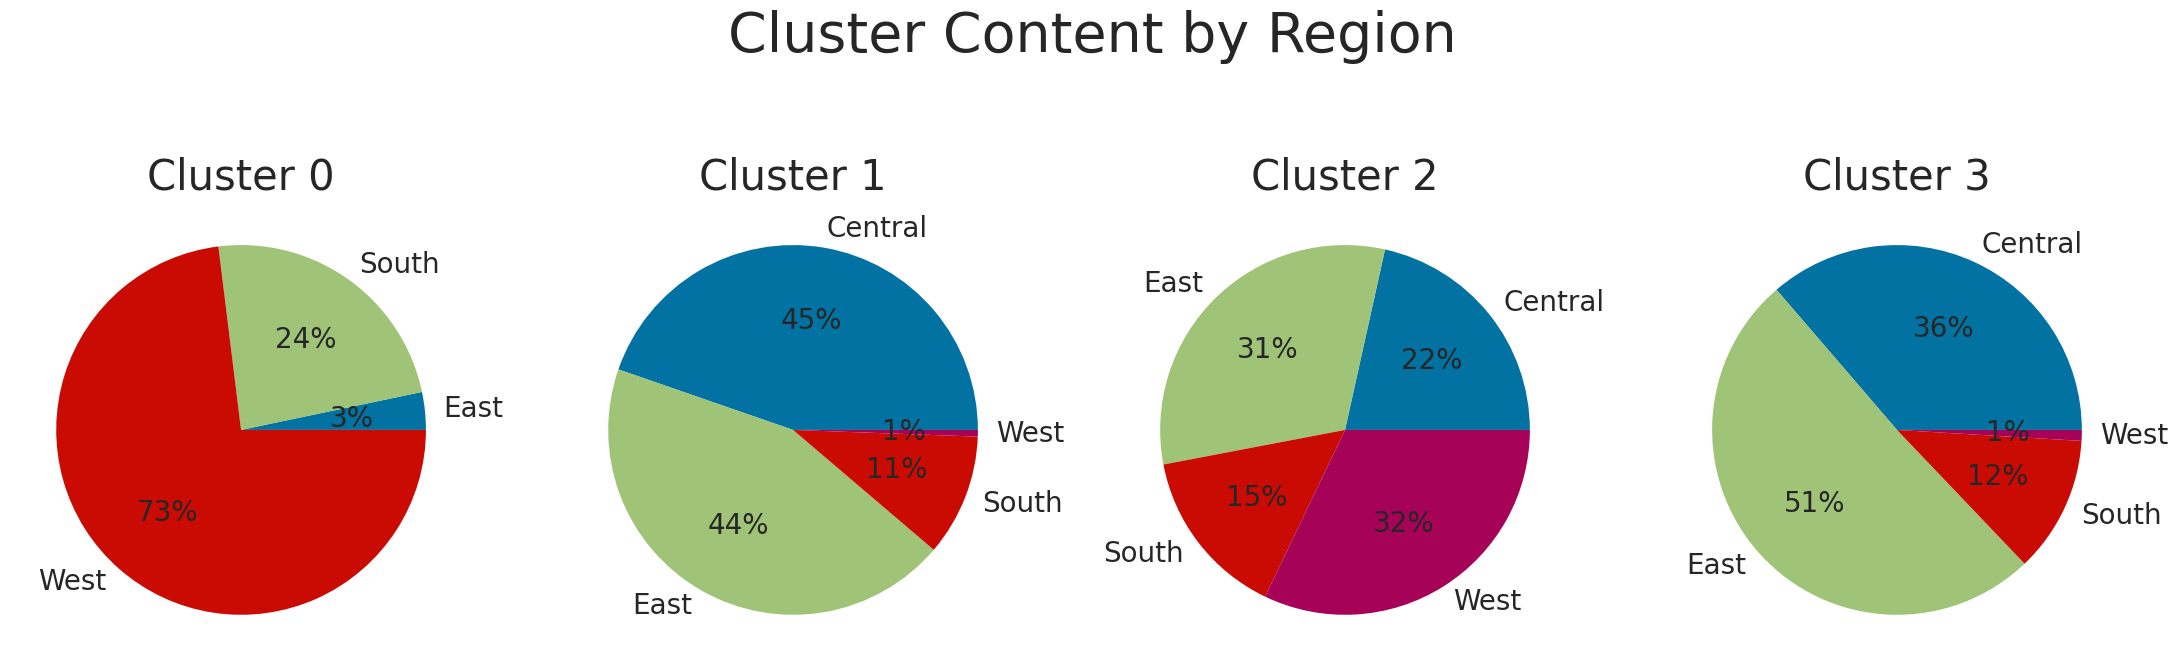

In [114]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(22,8))

data[data['Clusters 4'] == 0].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':20},ax=ax1)
data[data['Clusters 4'] == 1].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':20},ax=ax2)
data[data['Clusters 4'] == 2].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':20},ax=ax3)
data[data['Clusters 4'] == 3].groupby('Region').size().plot(kind='pie',autopct=label_function,textprops={'fontsize':20},ax=ax4)

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)
ax4.set_title('Cluster 3',size=30)

fig.suptitle("Cluster Content by Region",fontsize=40)
plt.tight_layout()

plt.show()

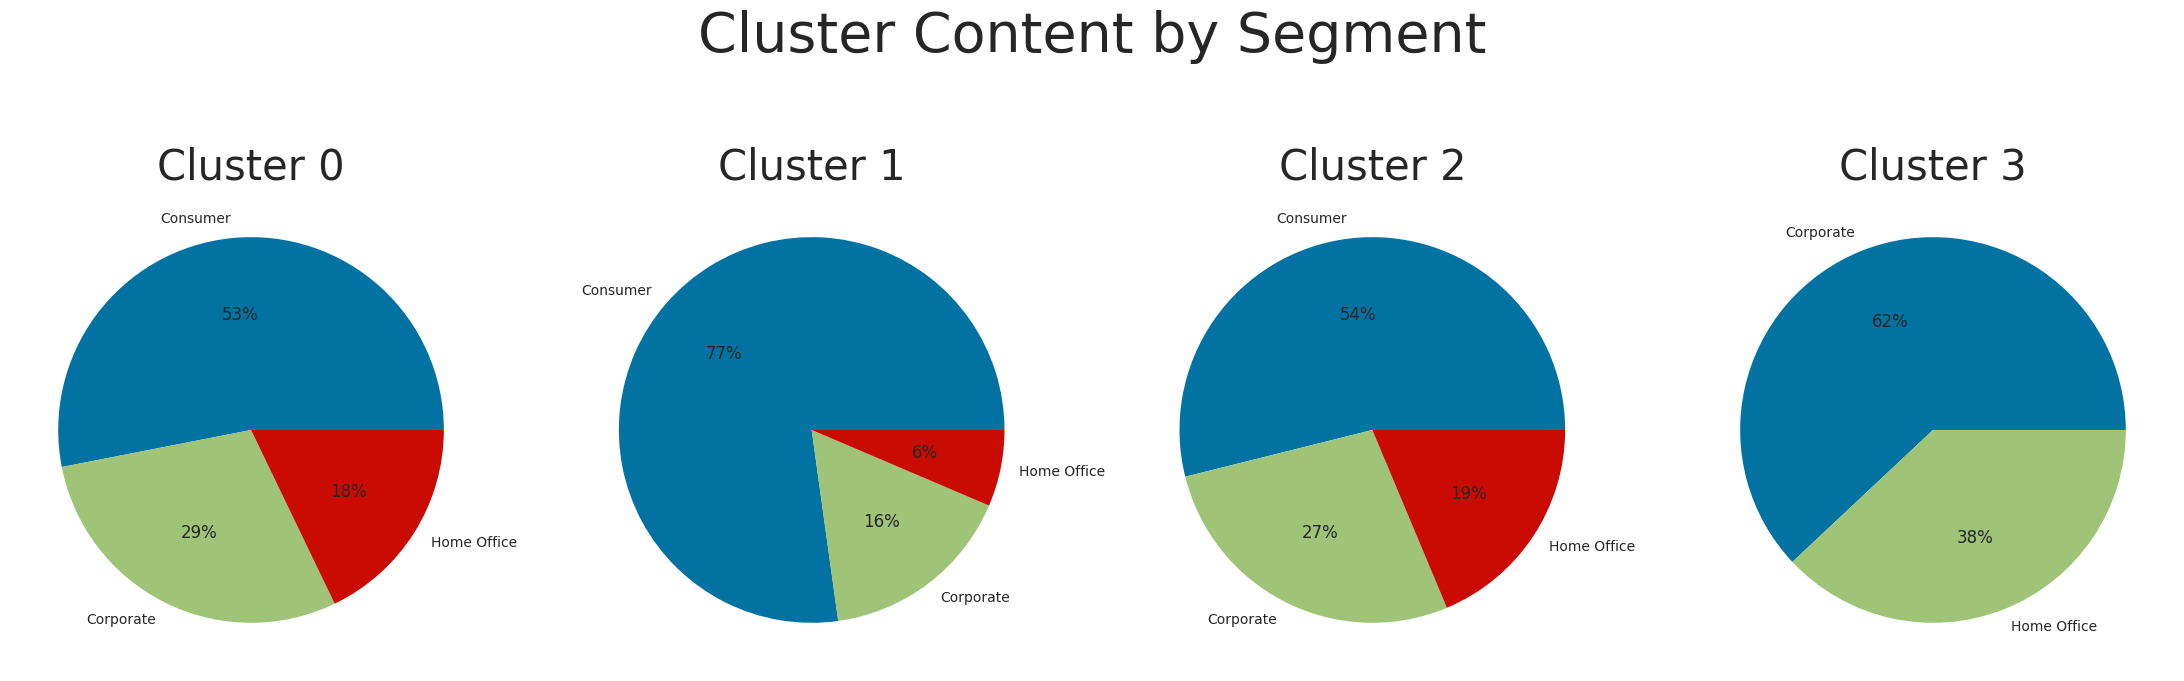

In [115]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(22,8))

data[data['Clusters 4'] == 0].groupby('Segment').size().plot(kind='pie',autopct=label_function,ax=ax1) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 1].groupby('Segment').size().plot(kind='pie',autopct=label_function,ax=ax2) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 2].groupby('Segment').size().plot(kind='pie',autopct=label_function,ax=ax3) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 3].groupby('Segment').size().plot(kind='pie',autopct=label_function,ax=ax4) #,textprops={'fontsize':16})

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)
ax4.set_title('Cluster 3',size=30)

fig.suptitle("Cluster Content by Segment",fontsize=40)
plt.tight_layout()

plt.show()

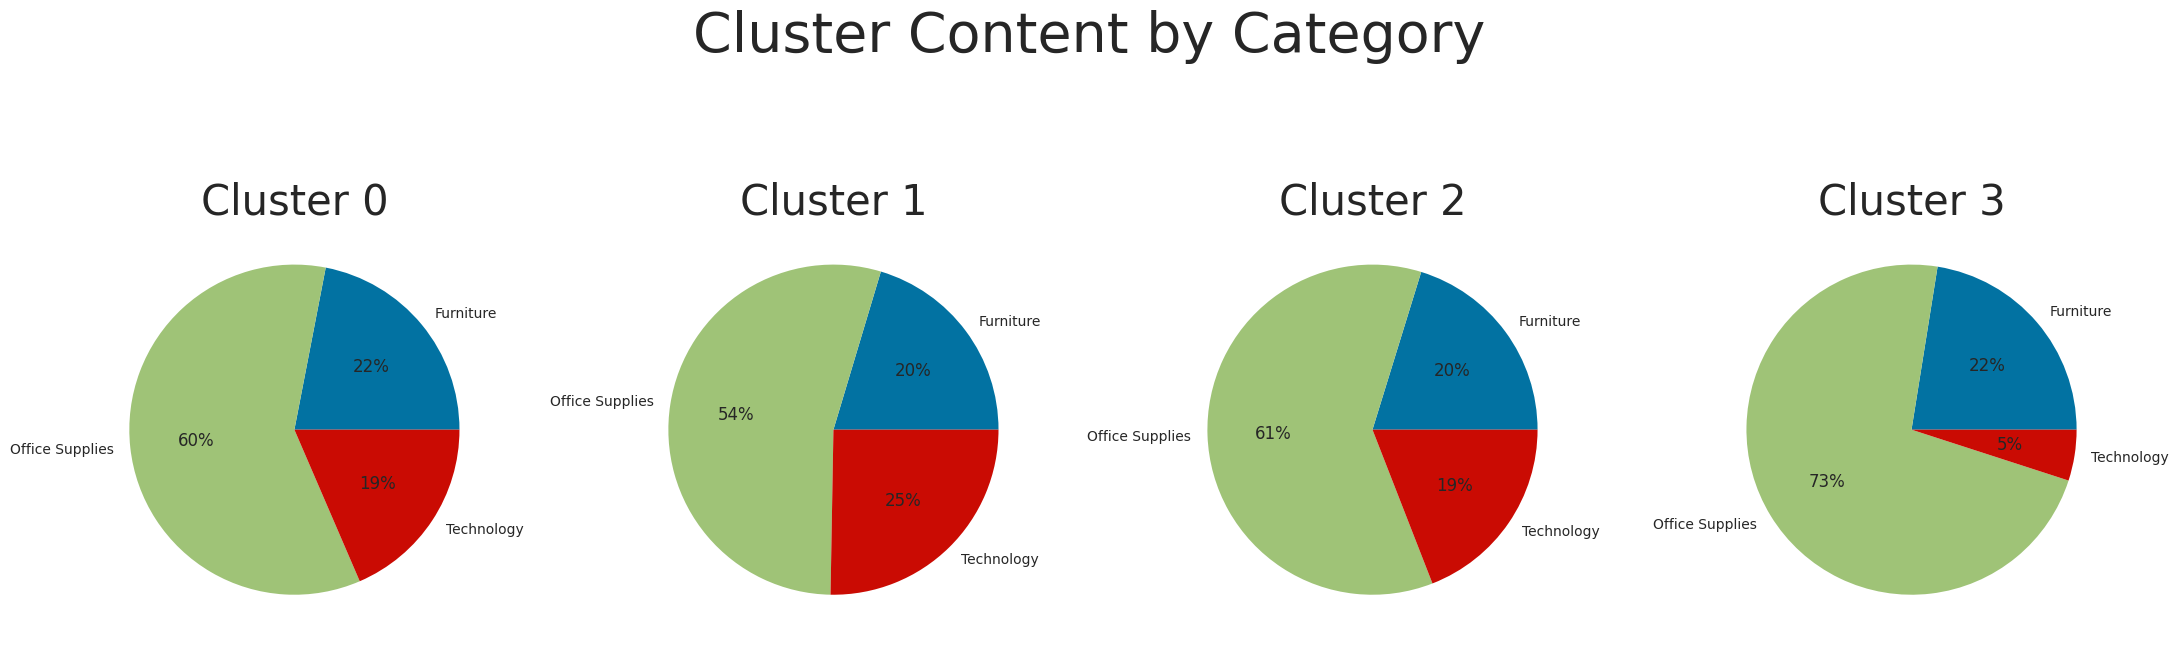

In [116]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(22,8))

data[data['Clusters 4'] == 0].groupby('Category').size().plot(kind='pie',autopct=label_function,ax=ax1) #,textprops={'fontsize':14})

data[data['Clusters 4'] == 1].groupby('Category').size().plot(kind='pie',autopct=label_function,ax=ax2) #,textprops={'fontsize':14})

data[data['Clusters 4'] == 2].groupby('Category').size().plot(kind='pie',autopct=label_function,ax=ax3) #,textprops={'fontsize':14})

data[data['Clusters 4'] == 3].groupby('Category').size().plot(kind='pie',autopct=label_function,ax=ax4) #,textprops={'fontsize':14})

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)
ax4.set_title('Cluster 3',size=30)

fig.suptitle("Cluster Content by Category",fontsize=40)
plt.tight_layout()

plt.show()

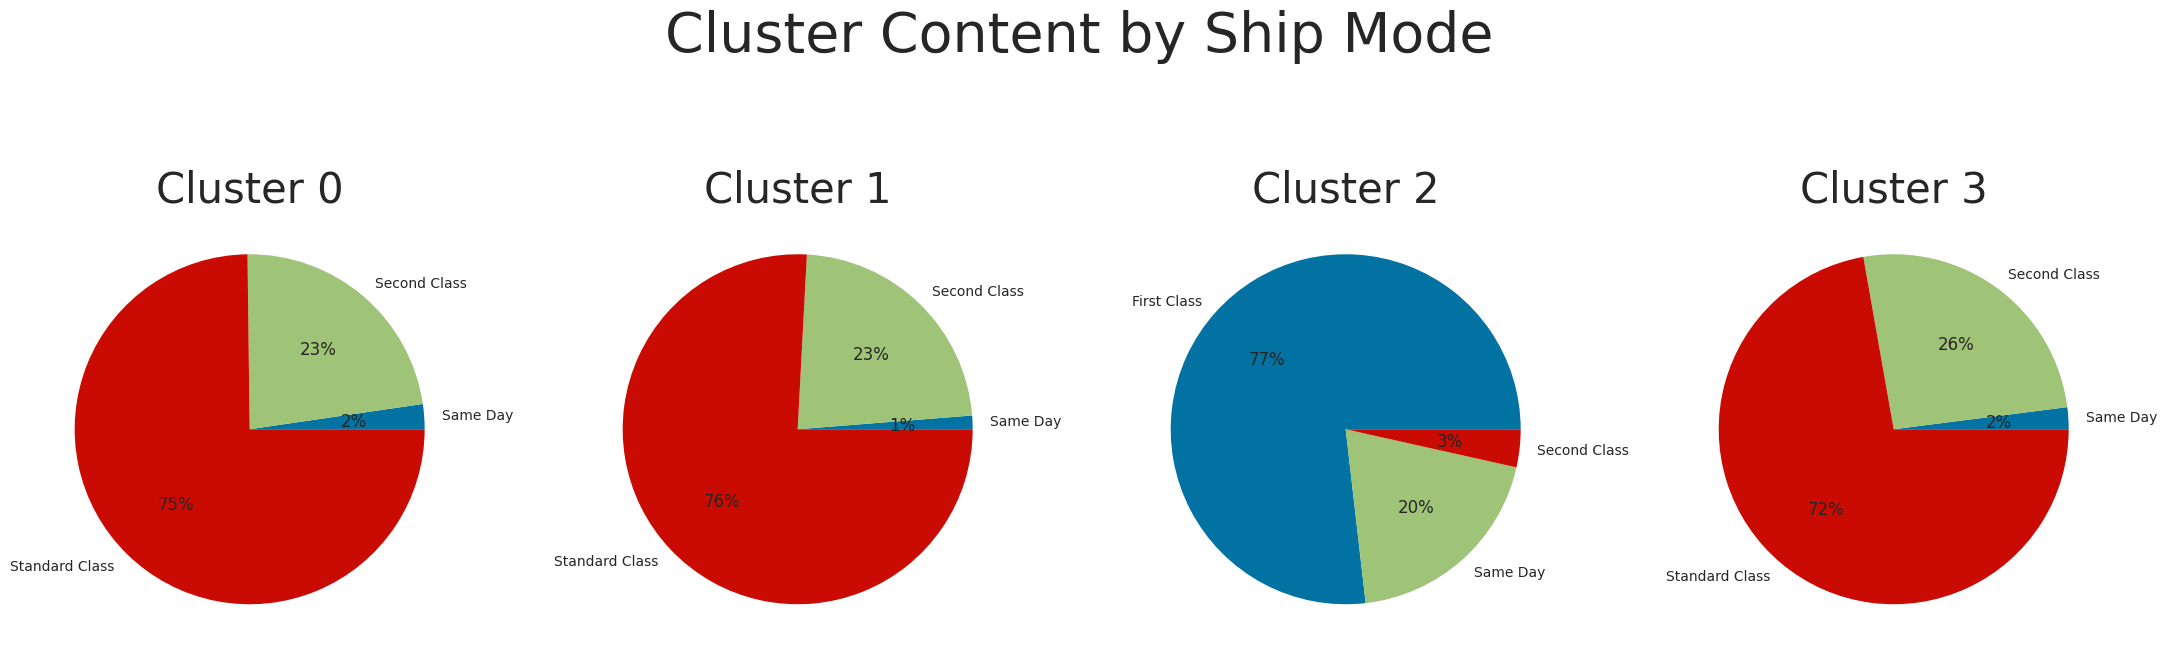

In [117]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(22,8))

data[data['Clusters 4'] == 0].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,ax=ax1) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 1].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,ax=ax2) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 2].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,ax=ax3) #,textprops={'fontsize':16})

data[data['Clusters 4'] == 3].groupby('Ship Mode').size().plot(kind='pie',autopct=label_function,ax=ax4) #,textprops={'fontsize':16})

ax1.set_title('Cluster 0',size=30)
ax2.set_title('Cluster 1',size=30)
ax3.set_title('Cluster 2',size=30)
ax4.set_title('Cluster 3',size=30)

fig.suptitle("Cluster Content by Ship Mode",fontsize=40)
plt.tight_layout()

plt.show()

In this second case it is more difficult to develop customer personas. This is why I conclude that the more appropriate segmentation of the customers is that based on three clusters.

<a id="6"></a>
## <b><div style='padding:15px;background-color:black;color:white;border-radius:40px;font-size:110%;text-align: left'>6. Final Insights</div></b>

## 1. Sales to Profit Ratio

The sales and profit grew almost constantly in the years 2014-2017. The sales to profit ratio increased between 2014 and 2015, but then it stayed quite stable. Therefore, in order to further increase the profit, the company should either increase its sales or the profit ratio, by cutting the unnecessary expenses.

## 2. Shipping

There are four shipping classes: Same Day, First Class, Second Class and Standard Class.
<br>The delivery distribution of the Same Day class has a high peak and also a much smaller one. The delivery distributions of the other 3 shipping classes are multi-peaked and they are also highly spread in time. Their delivery date is quite 'random'.

It would be very inportant to standardize the shipping deliveries in order to provide a better service.

## 3. Key Areas

California is the top selling state (20% of the sales), then New York (11%) and Texas (10%). New York and Los Angeles are the top selling cities. Moreover, more than half of the sales is generated in the top-20 cities of the USA.
<br> There are also cities (like Philadelphia and Houston) that constantly generate negative profits.

Something must be done. The company should either focus on specific areas of the country (the most profitable ones) or it should invest in order to improve its performance in the least profitable areas.

## 4. More and Less Profitable Product Categories

Technology and office supplies are quite profitable categories; furniture is much less. Moreover, there are sub-categories of products (like the tables) that generate negative profits.

Something must be done. Maybe some products should be either removed from the catalogue, or the discounts on them should be highly cut.

## 5. Customer Personas

The customers can be grouped in three spending (or better profit) categories. The highest value customers must be kept at any cost, while something should be done to make the lowest value customers rise to more profitable classes.

In [118]:
table_data = [['Cluster Number','Customer Persona','Profit','Discount','Ship Mode','Region','Customer value'],
             ['Cluster 0','Greedy Albert','Low','High','Standard Class','Everywhere in the US','**'],
             ['Cluster 1','Shopaholic Carlie','High','Low','Standard Class','West','****'],
             ['Cluster 2','Average Billy','Medium','Medium','First Class','Everywhere in the US','***']]

# Initialize a figure with FF.create_table(table_data)
figure = FF.create_table(table_data,height_constant=30)
figure.layout.width=1000

iplot(figure)

## <b><div style='padding:15px;background-color:navy;color:yellow;border-radius:40px;font-size:110%;text-align: left'>Useful Resources</div></b>

- https://www.kaggle.com/code/azizozmen/customer-segmentation-cohort-rfm-analysis-k-means
- https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars
- https://www.kaggle.com/code/tarundirector/sales-analysis-and-customer-segmentation-eda
- https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study